In [1]:
import glob, os, argparse, re, hashlib, uuid, collections, math, time

from itertools import islice
# import torch
# import torchaudio
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
import numpy as np

from dataloader import SpeechCommandsGoogle
import model as model_lib

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Set the matplotlib default settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Setup the directories
cwd = os.getcwd()
OK_DIR = os.path.dirname(cwd)
DATA_PATH = 'C:\\Users\\Weier Wan\\Documents\\neurram_data\\lstm\\'

In [2]:
import sys
sys.path.append(os.path.join(OK_DIR, 'python'))
import ok
import dac_control as dac
import adc_control as adc
import spi_control as spi
import wupdate_control as wupdate
import matmul
import nn_layers
from nn_layers import quantize_signed, quantize_signed_rescale, fake_quant_signed

In [3]:
# Set the DAC reference voltages
VDD = 5.0
dac.DAC_VREFS[3] = VDD
adc.C_INTEG = 1e-9


# Open the front panel API
dev = ok.okCFrontPanel()
print(dev.GetDeviceCount())
print(dev.GetDeviceListSerial(0))
print(dev.GetDeviceListSerial(1))
status = dev.OpenBySerial("1903000OQE")
print(status)

1
1903000OQE

0


In [4]:
status = dev.ConfigureFPGA(OK_DIR + "/HDL/neurram_48core/neurram_top.bit")
print(status)

0


In [363]:
# Global reset
dev.SetWireInValue(0x00, 0b11)
dev.UpdateWireIns()
dev.SetWireInValue(0x00, 0b00)
dev.UpdateWireIns()

0

In [5]:
die_info = np.load(OK_DIR + '/python/die_info.npy', allow_pickle=True).item()

In [5]:
for i in range(100):
    inp = np.random.binomial(n=2, p=0.5, size=[1,512])-1
    spi.spi_write(dev, row_addr=[0], forward=True, inputs=inp, shift_multiplier=1, pipe_in_steps=2, is_pipe_in=True)
    out = spi.spi_read(dev, row_addr=[0], num_words=32, forward=False, shift_multiplier=1, pipe_out_steps=2, is_pipe_out=True)
    if not (inp == out).all():
        print(i)
        print(inp)
        print(out)
        break

# Load LSTM checkpoint

In [8]:
# Setting parameters
background_frequency=0.8
background_volume=0.1
batch_size=64 #474
canonical_testing=False
cs=0.1
dataloader_num_workers=8
dataset_path_test='C:\\Users\\Weier Wan\\Documents\\dataset\\speech_commands_v0.02'
dataset_path_train='C:\\Users\\Weier Wan\\Documents\\dataset\\speech_commands_v0.02'
drop_p=0.0 #0.125
finetuning_epochs=10000
gain_blocks=2
hidden=112
hop_length=320
l2=0.01
learning_rate='0.002,0.0005,0.00008'
max_w=0.2
method=1
n_mfcc=40
n_msb=4
noise_injectionI=0.1 #0.1
noise_injectionT=0.16
pact_a=True
quant_actMVM=6
quant_actNM=8
quant_inp=4
num_bits = quant_inp
quant_w=None
random_seed=193012823
rows_bias=2*max_w
sample_rate=16000
silence_percentage=0.1
testing_percentage=10
time_shift_ms=100.0
training_steps='10000,10000,200'
unknown_percentage=0.1
validation_percentage=10
win_length=641
word_list=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
num_gate = 4
model_lib.max_w = max_w

In [3]:
torch.manual_seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda")    
    torch.backends.cudnn.benchmark=True 
else:
    device = torch.device("cpu")
    
epoch_list = np.cumsum([int(x) for x in training_steps.split(',')])
lr_list = [float(x) for x in learning_rate.split(',')]

torch.manual_seed(random_seed)
np.random.seed(random_seed)
mfcc_cuda = torchaudio.transforms.MFCC(sample_rate = sample_rate, n_mfcc = n_mfcc, log_mels = True, melkwargs= {'win_length' : win_length, 'hop_length' : hop_length, 'n_fft' : win_length, 'pad': 0, 'f_min' : 20, 'f_max': 4000, 'n_mels' : n_mfcc*4}).to(device)

# speech_dataset_train = SpeechCommandsGoogle(dataset_path_train, 'training', validation_percentage, testing_percentage,
#                                             word_list, sample_rate, batch_size, epoch_list[-1], device, background_volume, background_frequency, silence_percentage, unknown_percentage, time_shift_ms)

# speech_dataset_val = SpeechCommandsGoogle(dataset_path_train, 'validation', validation_percentage, testing_percentage,
#                                           word_list, sample_rate, batch_size, epoch_list[-1], device, 0., 0., silence_percentage, unknown_percentage, 0.)

speech_dataset_test = SpeechCommandsGoogle(dataset_path_train, 'testing', validation_percentage, testing_percentage, 
                                           word_list, sample_rate, batch_size, epoch_list[-1], device, 0., 0., silence_percentage, unknown_percentage, 0., non_canonical_test=not canonical_testing)


# train_dataloader = torch.utils.data.DataLoader(speech_dataset_train, batch_size=batch_size, shuffle=True, num_workers=dataloader_num_workers)
test_dataloader = torch.utils.data.DataLoader(speech_dataset_test, batch_size=batch_size, shuffle=True, num_workers=dataloader_num_workers)
# validation_dataloader = torch.utils.data.DataLoader(speech_dataset_val, batch_size=batch_size, shuffle=True, num_workers=dataloader_num_workers)





C:\Users\Weier Wan\.conda\envs\pytorch\lib\site-packages\torchaudio\functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (160) may be set too high. Or, the value for `n_freqs` (321) may be set too low.
  "At least one mel filterbank has all zero values. "


In [9]:
if method == 0:
    model = model_lib.KWS_LSTM_bmm(input_dim = n_mfcc, hidden_dim = hidden, output_dim = len(word_list), device = device, wb = quant_w, abMVM = quant_actMVM, abNM = quant_actNM, ib = quant_inp, noise_level = 0, drop_p = drop_p, n_msb = n_msb, pact_a = pact_a, bias_r = rows_bias)
elif method == 1:
    model = model_lib.KWS_LSTM_cs(input_dim = n_mfcc, hidden_dim = hidden, output_dim = len(word_list), device = device, wb = quant_w, abMVM = quant_actMVM, abNM = quant_actNM, ib = quant_inp, noise_level = 0, drop_p = drop_p, n_msb = n_msb, pact_a = pact_a, bias_r = 0.6)
elif method == 2:
    n_msb = int(n_msb/gain_blocks)
    model = model_lib.KWS_LSTM_mix(input_dim = n_mfcc, hidden_dim = hidden, output_dim = len(word_list), device = device, wb = quant_w, abMVM = quant_actMVM, abNM = quant_actNM, ib = quant_inp, noise_level = 0, drop_p = drop_p, n_msb = n_msb, pact_a = pact_a, bias_r = rows_bias, gain_blocks = gain_blocks)
else:
    raise Exception("Unknown method: Please use 0 for quantized LSTM blocks or 1 for bit splitting.")

model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr_list[0]) 
checkpoint_dict = torch.load('./checkpoints/max_w_0.2_bias_row_2.pkl', map_location=device)
model.load_state_dict(checkpoint_dict['model_dict'])
model.set_noise(noise_injectionI)
model.set_drop_p(0)

In [14]:
# Testing
print("Start testing:")
acc_aux = []

for i_batch, sample_batch in enumerate(test_dataloader):
    x_data, y_label = sample_batch
    x_data, y_label = model_lib.pre_processing(x_data, y_label, device, mfcc_cuda)

    output = model(x_data)
    acc_aux.append((output.argmax(dim=1) == y_label))

test_acc = torch.cat(acc_aux).float().mean().item()
print("Test Accuracy: {0:.4f}".format(test_acc))

Start testing:
Test Accuracy: 0.8710


In [6]:
weight_ih = model.lstmBlocks.cell.weight_ih.data.numpy()
weight_hh = model.lstmBlocks.cell.weight_hh.data.numpy()
bias_ih = model.lstmBlocks.cell.bias_ih.data.numpy()
bias_hh = model.lstmBlocks.cell.bias_hh.data.numpy()
a1 = model.lstmBlocks.cell.a1.data.numpy().reshape([4, 1, 1])
a2 = model.a2.data.numpy()
a3 = model.lstmBlocks.cell.a3.data.numpy().reshape([4, 1, 1])
a4 = model.lstmBlocks.cell.a4.data.numpy().reshape([4, 1, 1])
a5 = model.lstmBlocks.cell.a5.data.numpy().reshape([4, 1, 1])
a6 = model.lstmBlocks.cell.a6.data.numpy().reshape([4, 1, 1])
a7 = model.lstmBlocks.cell.a7.data.numpy().reshape([4, 1, 1])
a8 = model.lstmBlocks.cell.a8.data.numpy().reshape([4, 1, 1])
a9 = model.lstmBlocks.cell.a9.data.numpy().reshape([4, 1, 1])
a10 = model.lstmBlocks.cell.a10.data.numpy().reshape([4, 1, 1])
a11 = model.lstmBlocks.cell.a11.data.numpy().reshape([4, 1, 1])
a12 = model.lstmBlocks.cell.a12.data.numpy().reshape([4, 1, 1])
a13 = model.lstmBlocks.cell.a13.data.numpy().reshape([4, 1, 1])
a14 = model.lstmBlocks.cell.a14.data.numpy().reshape([4, 1, 1])

In [7]:
weight_ih_clip = np.clip(weight_ih, -max_w, max_w)
weight_hh_clip = np.clip(weight_hh, -max_w, max_w)
bias_ih_clip = np.clip(bias_ih, -rows_bias, rows_bias)
bias_hh_clip = np.clip(bias_hh, -rows_bias, rows_bias)
fc_a1 = model.finFC.a1.data.numpy().reshape([4, 1, 1])
fc_a2 = model.finFC.a2.data.numpy().reshape([4, 1, 1])

In [11]:
weight_fc = model.finFC.weights.data.numpy()
bias_fc = model.finFC.bias.data.numpy()
weight_fc_clip = np.clip(weight_fc, -max_w, max_w)
bias_fc_clip = np.clip(bias_fc, -rows_bias, rows_bias)

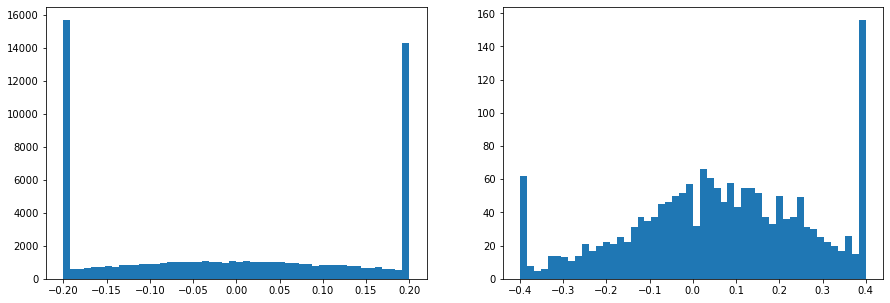

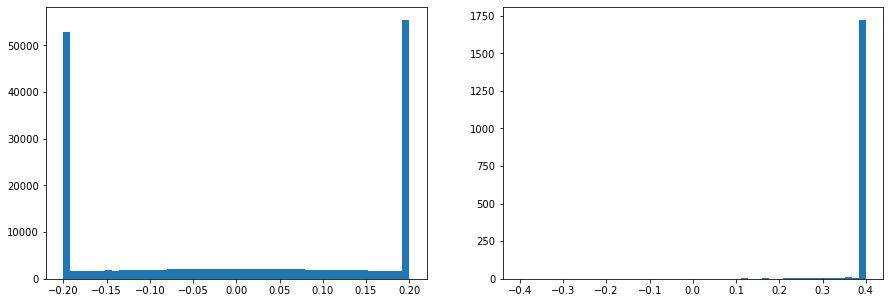

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(weight_ih_clip.flatten(), 50);
plt.subplot(122)
plt.hist(bias_ih_clip.flatten(), 50);

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(weight_hh_clip.flatten(), 50);
plt.subplot(122)
plt.hist(bias_hh_clip.flatten(), 50);

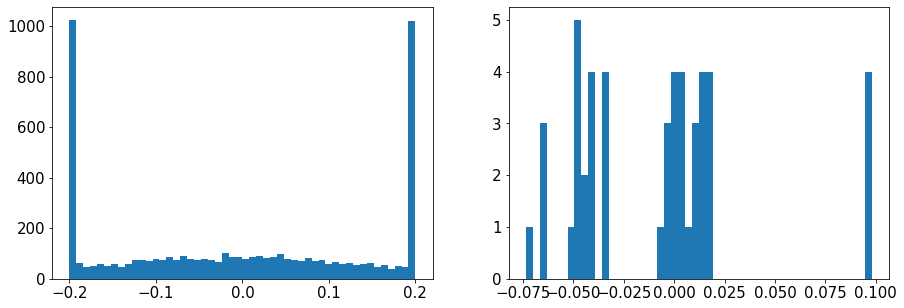

In [867]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(weight_fc_clip.flatten(), 50);
plt.subplot(122)
plt.hist(bias_fc_clip.flatten(), 50);

# Forming RRAMs

In [1234]:
chip = 5
core_row = 4
core_col = 3
die_info[chip][core_row][core_col]

{'unformed': [58, 135, 163, 219, 250], 'leaky': [117]}

In [31]:
# chip = 5
# core_row = 3
# core_col = 4

# bad_rows = []
# bad_cols = []

# # core_info = die_info[chip][core_row][core_col]
# # bad_rows = np.hstack([core_info['unformed'], core_info['leaky']])
# # if 'bad_cols' in core_info:
# #     bad_cols = core_info['bad_cols']

rows = [124] #np.delete(np.arange(256), bad_rows)[:]
# cols = np.delete(np.arange(256), bad_cols)[:1]

wupdate.ramp_up_voltage(dev, 3, 0, 4.2)
wupdate.ramp_up_voltage(dev, 3, 1, 1.5)
adc.adc_setup(dev, vread=1.0, vref=0.9)
spi.enable_single_core(dev, core_row, core_col)
vform = np.zeros([len(rows), len(cols)])
rform = np.zeros([len(rows), len(cols)])
for ri, r in enumerate(rows):
    for ci, c in enumerate(cols):
        vform[ri, ci], rform[ri, ci] = wupdate.find_vset_bl(dev, row=r, col=c, core_row=core_row, core_col=core_col, pulse_first=False,
                                                            vset_wl=1.5, vset_bl_start=4.2, vset_bl_end=4.5, tset=1e-3, r_target=8e5, tread=4000)
        print('finished %d row, %d column' % (r, c))


The cell has already been formed.
finished 124 row, 0 column
Vset = 4.200000, Rset = 105493.056414
finished 124 row, 1 column
The cell has already been formed.
finished 124 row, 2 column
Vset = 4.200000, Rset = 35669.748291
finished 124 row, 3 column
Vset = 4.200000, Rset = 29382.390374
finished 124 row, 4 column
Vset = 4.200000, Rset = 38737.988954
finished 124 row, 5 column
The cell has already been formed.
finished 124 row, 6 column
The cell has already been formed.
finished 124 row, 7 column
The cell has already been formed.
finished 124 row, 8 column
Vset = 4.200000, Rset = 28338.429263
finished 124 row, 9 column
Vset = 4.200000, Rset = 36357.439073
finished 124 row, 10 column
Vset = 4.200000, Rset = 159893.820510
finished 124 row, 11 column


In [1208]:
print((core_row, core_col))
ru = (rows[np.unique(np.where(~((rform>0) & (rform<1e6)))[0])])
print(ru)

(4, 3)
[]


In [943]:
rows_unform = ru.tolist()
rows_leaky = []
core = {'unformed':rows_unform, 'leaky':rows_leaky, 'bad_cols':[]}
# die_info[chip].append([])
die_info[chip][core_row].append(core)

In [944]:
np.save(OK_DIR + '/python/die_info', die_info)

In [402]:
die_info[chip][core_row][core_col]['leaky'].append(3)

In [1243]:
# Read single cell
adc.adc_setup(dev, vread=1.1, vref=0.9)
spi.enable_single_core(dev, core_row, core_col)
wupdate.write_reg(dev, 163, 0, core_row, core_col)
reads1 = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                     read_cycles=2, ignore_cycles=1, verbose=False)
print(reads1)

131379921.69146445


In [101]:
# Find the leaky row
row_unform = 58
spi.enable_single_core(dev, core_row, core_col)
for ri in rows[:]:
    wupdate.write_reg(dev, ri, 0, core_row, core_col)
    read1 = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                         read_cycles=2, ignore_cycles=1, verbose=False)
    wupdate.write_reg(dev, row_unform, 0, core_row, core_col)
    read_unform = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                         read_cycles=2, ignore_cycles=1, verbose=False)
    if read_unform < 1e8:
        print(read_unform)
        print(ri)

In [882]:
die_info[chip][core_row][core_col]['leaky'].append(164)
np.where(rows==164)

(array([161], dtype=int64),)

In [1640]:
# Find leaky columns
core_row = 7
core_col = 2
spi.enable_single_core(dev, core_row, core_col)
for i in range(110):
    wupdate.write_reg(dev, 0, i, core_row, core_col)
    reads = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                         read_cycles=1, ignore_cycles=0, verbose=False)
    if reads < 4e4:
        print((i, reads))

# Weight Mapping

In [9]:
tmp = np.load('weight_mapping_3.npz', allow_pickle=True)
core_row_list = tmp['core_row']
core_col_list = tmp['core_col']
rows_list = tmp['rows']
cols_list = tmp['cols']

In [12]:
num_rram = 0
for rows, cols in zip(rows_list, cols_list):
    num_rram += rows.size * cols.size
print(num_rram)

559104


In [24]:
g_max = 3e-5
g_min = 1e-6
g_tol = 1e-6

In [45]:
ih = 1
block = 0
gate = 0

if ih == 0:
    weight = weight_ih_clip[block, :, gate*hidden:(gate+1)*hidden]
    bias = bias_ih_clip[block, 0, gate*hidden:(gate+1)*hidden]
    relux = a1[block]
    out_clip = a12[block]
elif ih == 1:
    weight = weight_hh_clip[block, :, gate*hidden:(gate+1)*hidden]
    bias = bias_hh_clip[block, 0, gate*hidden:(gate+1)*hidden]
    relux = a11[block]
    out_clip = a13[block]
else:
    weight = weight_fc_clip[block, :, :]
    bias = bias_fc_clip[block, 0, :]
    relux = fc_a1[block]
    out_clip = fc_a2[block]
W = nn_layers.conv_filter_2_matrix(weight, bias*8/7, relux, num_bias=2, seg_length=114)[0]
G = nn_layers.weight_mapping(W, g_max, scheme='sign', w_max_percentile=100)

In [ ]:
idx = ih*16 + block*4  + gate
core_row = int(core_row_list[idx])
core_col = int(core_col_list[idx])
rows = rows_list[idx]
cols = cols_list[idx]

In [1513]:
chip = 5
core_row = 1
core_col = 2
core = die_info[chip][core_row][core_col]
bad_rows = np.hstack([core['unformed'], core['leaky']])
bad_cols = []
if 'bad_cols' in core:
    bad_cols = core['bad_cols']
rows = np.delete(np.arange(256), bad_rows)[:2*W.shape[0]]
cols = np.delete(np.arange(256), bad_cols)[:W.shape[1]]

C:\Users\Weier Wan\.conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if __name__ == '__main__':


In [13]:
tmp = np.load('fc_output_3.npz')
core_row_list_fc = tmp['core_row_list']
core_col_list_fc = tmp['core_col_list']
rows_list_fc = tmp['rows_list']
cols_list_fc = tmp['cols_list']

In [14]:
print(rows_list_fc.size)
for rows, cols in zip(rows_list_fc, cols_list_fc):
    num_rram += rows.size * cols.size
print(num_rram)

912
570048


In [15]:
rows_list_fc

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171,
        172, 173, 174, 175, 176, 177, 179, 180, 181

In [33]:
core_row = int(core_row_list_fc[block])
core_col = int(core_col_list_fc[block])
rows = rows_list_fc[block]
cols = cols_list_fc[block]

In [44]:
adc.adc_setup(dev, vread=1.1, vref=0.9)
wupdate.ramp_up_voltage(dev, 3, 0, 1.2)
wupdate.ramp_up_voltage(dev, 3, 1, 3.3)
wupdate.ramp_up_voltage(dev, 3, 2, 2.5)
spi.enable_single_core(dev, core_row, core_col)

program_sucess, G_program, num_pulses, _ = wupdate.program_array(
    dev, rows[:], cols[:], core_row, core_col, G[:, :], g_min, g_tol, 1, end_voltage=4.0, vread=1.1, vref=0.9, vset_wl=3.3, iteration_limit=30)

RRAM is programmed within the range.
Finished programming 0 row 0 col
RRAM is programmed within the range.
Finished programming 0 row 1 col
RRAM is programmed within the range.
Finished programming 0 row 2 col
RRAM is programmed within the range.
Finished programming 0 row 3 col
RRAM is programmed within the range.
Finished programming 0 row 4 col
RRAM is programmed within the range.
Finished programming 0 row 5 col
RRAM is programmed within the range.
Finished programming 0 row 6 col
RRAM is programmed within the range.
Finished programming 0 row 7 col
RRAM is programmed within the range.
Finished programming 0 row 8 col
RRAM is programmed within the range.
Finished programming 0 row 9 col
RRAM is programmed within the range.
Finished programming 0 row 10 col
RRAM is programmed within the range.
Finished programming 0 row 11 col
RRAM is programmed within the range.
Finished programming 1 row 0 col
RRAM is programmed within the range.
Finished programming 1 row 1 col
RRAM is programmed

RRAM is programmed within the range.
Finished programming 9 row 9 col
RRAM is programmed within the range.
Finished programming 9 row 10 col
RRAM is programmed within the range.
Finished programming 9 row 11 col
RRAM is programmed within the range.
Finished programming 10 row 0 col
RRAM is programmed within the range.
Finished programming 10 row 1 col
RRAM is programmed within the range.
Finished programming 10 row 2 col
RRAM is programmed within the range.
Finished programming 10 row 3 col
RRAM is programmed within the range.
Finished programming 10 row 4 col
RRAM is programmed within the range.
Finished programming 10 row 5 col
RRAM is programmed within the range.
Finished programming 10 row 6 col
RRAM is programmed within the range.
Finished programming 10 row 7 col
RRAM is programmed within the range.
Finished programming 10 row 8 col
RRAM is programmed within the range.
Finished programming 10 row 9 col
RRAM is programmed within the range.
Finished programming 10 row 10 col
RRAM i

RRAM is programmed within the range.
Finished programming 19 row 9 col
RRAM is programmed within the range.
Finished programming 19 row 10 col
RRAM is programmed within the range.
Finished programming 19 row 11 col
RRAM is programmed within the range.
Finished programming 21 row 0 col
RRAM is programmed within the range.
Finished programming 21 row 1 col
RRAM is programmed within the range.
Finished programming 21 row 2 col
RRAM is programmed within the range.
Finished programming 21 row 3 col
RRAM is programmed within the range.
Finished programming 21 row 4 col
RRAM is programmed within the range.
Finished programming 21 row 5 col
RRAM is programmed within the range.
Finished programming 21 row 6 col
RRAM is programmed within the range.
Finished programming 21 row 7 col
RRAM is programmed within the range.
Finished programming 21 row 8 col
RRAM is programmed within the range.
Finished programming 21 row 9 col
RRAM is programmed within the range.
Finished programming 21 row 10 col
RRA

RRAM is programmed within the range.
Finished programming 30 row 5 col
RRAM is programmed within the range.
Finished programming 30 row 6 col
RRAM is programmed within the range.
Finished programming 30 row 7 col
RRAM is programmed within the range.
Finished programming 30 row 8 col
RRAM is programmed within the range.
Finished programming 30 row 9 col
RRAM is programmed within the range.
Finished programming 30 row 10 col
RRAM is programmed within the range.
Finished programming 30 row 11 col
RRAM is programmed within the range.
Finished programming 31 row 0 col
RRAM is programmed within the range.
Finished programming 31 row 1 col
RRAM is programmed within the range.
Finished programming 31 row 2 col
RRAM is programmed within the range.
Finished programming 31 row 3 col
RRAM is programmed within the range.
Finished programming 31 row 4 col
RRAM is programmed within the range.
Finished programming 31 row 5 col
RRAM is programmed within the range.
Finished programming 31 row 6 col
RRAM

RRAM is programmed within the range.
Finished programming 40 row 2 col
RRAM is programmed within the range.
Finished programming 40 row 3 col
RRAM is programmed within the range.
Finished programming 40 row 4 col
RRAM is programmed within the range.
Finished programming 40 row 5 col
RRAM is programmed within the range.
Finished programming 40 row 6 col
RRAM is programmed within the range.
Finished programming 40 row 7 col
RRAM is programmed within the range.
Finished programming 40 row 8 col
RRAM is programmed within the range.
Finished programming 40 row 9 col
RRAM is programmed within the range.
Finished programming 40 row 10 col
RRAM is programmed within the range.
Finished programming 40 row 11 col
RRAM is programmed within the range.
Finished programming 41 row 0 col
RRAM is programmed within the range.
Finished programming 41 row 1 col
RRAM is programmed within the range.
Finished programming 41 row 2 col
RRAM is programmed within the range.
Finished programming 41 row 3 col
RRAM

RRAM is programmed within the range.
Finished programming 50 row 11 col
RRAM is programmed within the range.
Finished programming 51 row 0 col
RRAM is programmed within the range.
Finished programming 51 row 1 col
RRAM is programmed within the range.
Finished programming 51 row 2 col
RRAM is programmed within the range.
Finished programming 51 row 3 col
RRAM is programmed within the range.
Finished programming 51 row 4 col
RRAM is programmed within the range.
Finished programming 51 row 5 col
RRAM is programmed within the range.
Finished programming 51 row 6 col
RRAM is programmed within the range.
Finished programming 51 row 7 col
RRAM is programmed within the range.
Finished programming 51 row 8 col
RRAM is programmed within the range.
Finished programming 51 row 9 col
RRAM is programmed within the range.
Finished programming 51 row 10 col
RRAM is programmed within the range.
Finished programming 51 row 11 col
RRAM is programmed within the range.
Finished programming 52 row 0 col
RRA

RRAM is programmed within the range.
Finished programming 60 row 8 col
RRAM is programmed within the range.
Finished programming 60 row 9 col
RRAM is programmed within the range.
Finished programming 60 row 10 col
RRAM is programmed within the range.
Finished programming 60 row 11 col
RRAM is programmed within the range.
Finished programming 61 row 0 col
RRAM is programmed within the range.
Finished programming 61 row 1 col
RRAM is programmed within the range.
Finished programming 61 row 2 col
RRAM is programmed within the range.
Finished programming 61 row 3 col
RRAM is programmed within the range.
Finished programming 61 row 4 col
RRAM is programmed within the range.
Finished programming 61 row 5 col
RRAM is programmed within the range.
Finished programming 61 row 6 col
RRAM is programmed within the range.
Finished programming 61 row 7 col
RRAM is programmed within the range.
Finished programming 61 row 8 col
RRAM is programmed within the range.
Finished programming 61 row 9 col
RRAM

RRAM is programmed within the range.
Finished programming 70 row 6 col
RRAM is programmed within the range.
Finished programming 70 row 7 col
RRAM is programmed within the range.
Finished programming 70 row 8 col
RRAM is programmed within the range.
Finished programming 70 row 9 col
RRAM is programmed within the range.
Finished programming 70 row 10 col
RRAM is programmed within the range.
Finished programming 70 row 11 col
RRAM is programmed within the range.
Finished programming 71 row 0 col
RRAM is programmed within the range.
Finished programming 71 row 1 col
RRAM is programmed within the range.
Finished programming 71 row 2 col
RRAM is programmed within the range.
Finished programming 71 row 3 col
RRAM is programmed within the range.
Finished programming 71 row 4 col
RRAM is programmed within the range.
Finished programming 71 row 5 col
RRAM is programmed within the range.
Finished programming 71 row 6 col
RRAM is programmed within the range.
Finished programming 71 row 7 col
RRAM

RRAM is programmed within the range.
Finished programming 80 row 2 col
RRAM is programmed within the range.
Finished programming 80 row 3 col
RRAM is programmed within the range.
Finished programming 80 row 4 col
RRAM is programmed within the range.
Finished programming 80 row 5 col
RRAM is programmed within the range.
Finished programming 80 row 6 col
RRAM is programmed within the range.
Finished programming 80 row 7 col
RRAM is programmed within the range.
Finished programming 80 row 8 col
RRAM is programmed within the range.
Finished programming 80 row 9 col
RRAM is programmed within the range.
Finished programming 80 row 10 col
RRAM is programmed within the range.
Finished programming 80 row 11 col
RRAM is programmed within the range.
Finished programming 81 row 0 col
RRAM is programmed within the range.
Finished programming 81 row 1 col
RRAM is programmed within the range.
Finished programming 81 row 2 col
RRAM is programmed within the range.
Finished programming 81 row 3 col
RRAM

RRAM is programmed within the range.
Finished programming 89 row 11 col
RRAM is programmed within the range.
Finished programming 90 row 0 col
RRAM is programmed within the range.
Finished programming 90 row 1 col
RRAM is programmed within the range.
Finished programming 90 row 2 col
RRAM is programmed within the range.
Finished programming 90 row 3 col
RRAM is programmed within the range.
Finished programming 90 row 4 col
RRAM is programmed within the range.
Finished programming 90 row 5 col
RRAM is programmed within the range.
Finished programming 90 row 6 col
RRAM is programmed within the range.
Finished programming 90 row 7 col
RRAM is programmed within the range.
Finished programming 90 row 8 col
RRAM is programmed within the range.
Finished programming 90 row 9 col
RRAM is programmed within the range.
Finished programming 90 row 10 col
RRAM is programmed within the range.
Finished programming 90 row 11 col
RRAM is programmed within the range.
Finished programming 91 row 0 col
RRA

RRAM is programmed within the range.
Finished programming 99 row 9 col
RRAM is programmed within the range.
Finished programming 99 row 10 col
RRAM is programmed within the range.
Finished programming 99 row 11 col
RRAM is programmed within the range.
Finished programming 100 row 0 col
RRAM is programmed within the range.
Finished programming 100 row 1 col
RRAM is programmed within the range.
Finished programming 100 row 2 col
RRAM is programmed within the range.
Finished programming 100 row 3 col
RRAM is programmed within the range.
Finished programming 100 row 4 col
RRAM is programmed within the range.
Finished programming 100 row 5 col
RRAM is programmed within the range.
Finished programming 100 row 6 col
RRAM is programmed within the range.
Finished programming 100 row 7 col
RRAM is programmed within the range.
Finished programming 100 row 8 col
RRAM is programmed within the range.
Finished programming 100 row 9 col
RRAM is programmed within the range.
Finished programming 100 row

RRAM is programmed within the range.
Finished programming 109 row 4 col
RRAM is programmed within the range.
Finished programming 109 row 5 col
RRAM is programmed within the range.
Finished programming 109 row 6 col
RRAM is programmed within the range.
Finished programming 109 row 7 col
RRAM is programmed within the range.
Finished programming 109 row 8 col
RRAM is programmed within the range.
Finished programming 109 row 9 col
RRAM is programmed within the range.
Finished programming 109 row 10 col
RRAM is programmed within the range.
Finished programming 109 row 11 col
RRAM is programmed within the range.
Finished programming 110 row 0 col
RRAM is programmed within the range.
Finished programming 110 row 1 col
RRAM is programmed within the range.
Finished programming 110 row 2 col
RRAM is programmed within the range.
Finished programming 110 row 3 col
RRAM is programmed within the range.
Finished programming 110 row 4 col
RRAM is programmed within the range.
Finished programming 110 

RRAM is programmed within the range.
Finished programming 118 row 11 col
RRAM is programmed within the range.
Finished programming 119 row 0 col
RRAM is programmed within the range.
Finished programming 119 row 1 col
RRAM is programmed within the range.
Finished programming 119 row 2 col
RRAM is programmed within the range.
Finished programming 119 row 3 col
RRAM is programmed within the range.
Finished programming 119 row 4 col
RRAM is programmed within the range.
Finished programming 119 row 5 col
RRAM is programmed within the range.
Finished programming 119 row 6 col
RRAM is programmed within the range.
Finished programming 119 row 7 col
RRAM is programmed within the range.
Finished programming 119 row 8 col
RRAM is programmed within the range.
Finished programming 119 row 9 col
RRAM is programmed within the range.
Finished programming 119 row 10 col
RRAM is programmed within the range.
Finished programming 119 row 11 col
RRAM is programmed within the range.
Finished programming 120

RRAM is programmed within the range.
Finished programming 128 row 7 col
RRAM is programmed within the range.
Finished programming 128 row 8 col
RRAM is programmed within the range.
Finished programming 128 row 9 col
RRAM is programmed within the range.
Finished programming 128 row 10 col
RRAM is programmed within the range.
Finished programming 128 row 11 col
RRAM is programmed within the range.
Finished programming 129 row 0 col
RRAM is programmed within the range.
Finished programming 129 row 1 col
RRAM is programmed within the range.
Finished programming 129 row 2 col
RRAM is programmed within the range.
Finished programming 129 row 3 col
RRAM is programmed within the range.
Finished programming 129 row 4 col
RRAM is programmed within the range.
Finished programming 129 row 5 col
RRAM is programmed within the range.
Finished programming 129 row 6 col
RRAM is programmed within the range.
Finished programming 129 row 7 col
RRAM is programmed within the range.
Finished programming 129 

RRAM is programmed within the range.
Finished programming 138 row 2 col
RRAM is programmed within the range.
Finished programming 138 row 3 col
RRAM is programmed within the range.
Finished programming 138 row 4 col
RRAM is programmed within the range.
Finished programming 138 row 5 col
RRAM is programmed within the range.
Finished programming 138 row 6 col
RRAM is programmed within the range.
Finished programming 138 row 7 col
RRAM is programmed within the range.
Finished programming 138 row 8 col
RRAM is programmed within the range.
Finished programming 138 row 9 col
RRAM is programmed within the range.
Finished programming 138 row 10 col
RRAM is programmed within the range.
Finished programming 138 row 11 col
RRAM is programmed within the range.
Finished programming 139 row 0 col
RRAM is programmed within the range.
Finished programming 139 row 1 col
RRAM is programmed within the range.
Finished programming 139 row 2 col
RRAM is programmed within the range.
Finished programming 139 

RRAM is programmed within the range.
Finished programming 147 row 10 col
RRAM is programmed within the range.
Finished programming 147 row 11 col
RRAM is programmed within the range.
Finished programming 148 row 0 col
RRAM is programmed within the range.
Finished programming 148 row 1 col
RRAM is programmed within the range.
Finished programming 148 row 2 col
RRAM is programmed within the range.
Finished programming 148 row 3 col
RRAM is programmed within the range.
Finished programming 148 row 4 col
RRAM is programmed within the range.
Finished programming 148 row 5 col
RRAM is programmed within the range.
Finished programming 148 row 6 col
RRAM is programmed within the range.
Finished programming 148 row 7 col
RRAM is programmed within the range.
Finished programming 148 row 8 col
RRAM is programmed within the range.
Finished programming 148 row 9 col
RRAM is programmed within the range.
Finished programming 148 row 10 col
RRAM is programmed within the range.
Finished programming 148

RRAM is programmed within the range.
Finished programming 157 row 5 col
RRAM is programmed within the range.
Finished programming 157 row 6 col
RRAM is programmed within the range.
Finished programming 157 row 7 col
RRAM is programmed within the range.
Finished programming 157 row 8 col
RRAM is programmed within the range.
Finished programming 157 row 9 col
RRAM is programmed within the range.
Finished programming 157 row 10 col
RRAM is programmed within the range.
Finished programming 157 row 11 col
RRAM is programmed within the range.
Finished programming 158 row 0 col
RRAM is programmed within the range.
Finished programming 158 row 1 col
RRAM is programmed within the range.
Finished programming 158 row 2 col
RRAM is programmed within the range.
Finished programming 158 row 3 col
RRAM is programmed within the range.
Finished programming 158 row 4 col
RRAM is programmed within the range.
Finished programming 158 row 5 col
RRAM is programmed within the range.
Finished programming 158 

RRAM is programmed within the range.
Finished programming 168 row 1 col
RRAM is programmed within the range.
Finished programming 168 row 2 col
RRAM is programmed within the range.
Finished programming 168 row 3 col
RRAM is programmed within the range.
Finished programming 168 row 4 col
RRAM is programmed within the range.
Finished programming 168 row 5 col
RRAM is programmed within the range.
Finished programming 168 row 6 col
RRAM is programmed within the range.
Finished programming 168 row 7 col
RRAM is programmed within the range.
Finished programming 168 row 8 col
RRAM is programmed within the range.
Finished programming 168 row 9 col
RRAM is programmed within the range.
Finished programming 168 row 10 col
RRAM is programmed within the range.
Finished programming 168 row 11 col
RRAM is programmed within the range.
Finished programming 169 row 0 col
RRAM is programmed within the range.
Finished programming 169 row 1 col
RRAM is programmed within the range.
Finished programming 169 

RRAM is programmed within the range.
Finished programming 177 row 7 col
RRAM is programmed within the range.
Finished programming 177 row 8 col
RRAM is programmed within the range.
Finished programming 177 row 9 col
RRAM is programmed within the range.
Finished programming 177 row 10 col
RRAM is programmed within the range.
Finished programming 177 row 11 col
RRAM is programmed within the range.
Finished programming 179 row 0 col
RRAM is programmed within the range.
Finished programming 179 row 1 col
RRAM is programmed within the range.
Finished programming 179 row 2 col
RRAM is programmed within the range.
Finished programming 179 row 3 col
RRAM is programmed within the range.
Finished programming 179 row 4 col
RRAM is programmed within the range.
Finished programming 179 row 5 col
RRAM is programmed within the range.
Finished programming 179 row 6 col
RRAM is programmed within the range.
Finished programming 179 row 7 col
RRAM is programmed within the range.
Finished programming 179 

RRAM is programmed within the range.
Finished programming 188 row 3 col
RRAM is programmed within the range.
Finished programming 188 row 4 col
RRAM is programmed within the range.
Finished programming 188 row 5 col
RRAM is programmed within the range.
Finished programming 188 row 6 col
RRAM is programmed within the range.
Finished programming 188 row 7 col
RRAM is programmed within the range.
Finished programming 188 row 8 col
RRAM is programmed within the range.
Finished programming 188 row 9 col
RRAM is programmed within the range.
Finished programming 188 row 10 col
RRAM is programmed within the range.
Finished programming 188 row 11 col
RRAM is programmed within the range.
Finished programming 189 row 0 col
RRAM is programmed within the range.
Finished programming 189 row 1 col
RRAM is programmed within the range.
Finished programming 189 row 2 col
RRAM is programmed within the range.
Finished programming 189 row 3 col
RRAM is programmed within the range.
Finished programming 189 

RRAM is programmed within the range.
Finished programming 198 row 9 col
RRAM is programmed within the range.
Finished programming 198 row 10 col
RRAM is programmed within the range.
Finished programming 198 row 11 col
RRAM is programmed within the range.
Finished programming 199 row 0 col
RRAM is programmed within the range.
Finished programming 199 row 1 col
RRAM is programmed within the range.
Finished programming 199 row 2 col
RRAM is programmed within the range.
Finished programming 199 row 3 col
RRAM is programmed within the range.
Finished programming 199 row 4 col
RRAM is programmed within the range.
Finished programming 199 row 5 col
RRAM is programmed within the range.
Finished programming 199 row 6 col
RRAM is programmed within the range.
Finished programming 199 row 7 col
RRAM is programmed within the range.
Finished programming 199 row 8 col
RRAM is programmed within the range.
Finished programming 199 row 9 col
RRAM is programmed within the range.
Finished programming 199 

RRAM is programmed within the range.
Finished programming 208 row 3 col
RRAM is programmed within the range.
Finished programming 208 row 4 col
RRAM is programmed within the range.
Finished programming 208 row 5 col
RRAM is programmed within the range.
Finished programming 208 row 6 col
RRAM is programmed within the range.
Finished programming 208 row 7 col
RRAM is programmed within the range.
Finished programming 208 row 8 col
RRAM is programmed within the range.
Finished programming 208 row 9 col
RRAM is programmed within the range.
Finished programming 208 row 10 col
RRAM is programmed within the range.
Finished programming 208 row 11 col
RRAM is programmed within the range.
Finished programming 209 row 0 col
RRAM is programmed within the range.
Finished programming 209 row 1 col
RRAM is programmed within the range.
Finished programming 209 row 2 col
RRAM is programmed within the range.
Finished programming 209 row 3 col
RRAM is programmed within the range.
Finished programming 209 

RRAM is programmed within the range.
Finished programming 218 row 9 col
RRAM is programmed within the range.
Finished programming 218 row 10 col
RRAM is programmed within the range.
Finished programming 218 row 11 col
RRAM is programmed within the range.
Finished programming 219 row 0 col
RRAM is programmed within the range.
Finished programming 219 row 1 col
RRAM is programmed within the range.
Finished programming 219 row 2 col
RRAM is programmed within the range.
Finished programming 219 row 3 col
RRAM is programmed within the range.
Finished programming 219 row 4 col
RRAM is programmed within the range.
Finished programming 219 row 5 col
RRAM is programmed within the range.
Finished programming 219 row 6 col
RRAM is programmed within the range.
Finished programming 219 row 7 col
RRAM is programmed within the range.
Finished programming 219 row 8 col
RRAM is programmed within the range.
Finished programming 219 row 9 col
RRAM is programmed within the range.
Finished programming 219 

RRAM is programmed within the range.
Finished programming 229 row 4 col
RRAM is programmed within the range.
Finished programming 229 row 5 col
RRAM is programmed within the range.
Finished programming 229 row 6 col
RRAM is programmed within the range.
Finished programming 229 row 7 col
RRAM is programmed within the range.
Finished programming 229 row 8 col
RRAM is programmed within the range.
Finished programming 229 row 9 col
RRAM is programmed within the range.
Finished programming 229 row 10 col
RRAM is programmed within the range.
Finished programming 229 row 11 col
RRAM is programmed within the range.
Finished programming 230 row 0 col
RRAM is programmed within the range.
Finished programming 230 row 1 col
RRAM is programmed within the range.
Finished programming 230 row 2 col
RRAM is programmed within the range.
Finished programming 230 row 3 col
RRAM is programmed within the range.
Finished programming 230 row 4 col
RRAM is programmed within the range.
Finished programming 230 

In [45]:
print((core_row, core_col))
print(np.sum(~program_sucess)/program_sucess.size)
print(np.argwhere(~program_sucess))
print(G[:, :][~program_sucess])
print(G_program[~program_sucess])

(0, 4)
0.0007309941520467836
[[28  3]
 [35  9]]
[2.99999992e-05 2.24016949e-05]
[3.12951660e-05 2.64196777e-05]


In [809]:
# core_row_list = []
# core_col_list = []
# rows_list = []
# cols_list = []
program_sucess_list = []
G_program_list = []

In [876]:
RESTART = False

adc.adc_setup(dev, vread=1.1, vref=0.9)
wupdate.ramp_up_voltage(dev, 3, 0, 1.2)
wupdate.ramp_up_voltage(dev, 3, 1, 3.3)
wupdate.ramp_up_voltage(dev, 3, 2, 2.5)
for ih in range(1, 2):
    for block in range(4):
        for gate in range(4):
            if ih == 0:
                weight = weight_ih_clip[block, :, gate*hidden:(gate+1)*hidden]
                bias = bias_ih_clip[block, 0, gate*hidden:(gate+1)*hidden]
                relux = a1[block]
            else:
                weight = weight_hh_clip[block, :, gate*hidden:(gate+1)*hidden]
                bias = bias_hh_clip[block, 0, gate*hidden:(gate+1)*hidden]
                relux = a11[block]
            W = nn_layers.conv_filter_2_matrix(weight, bias*8/7, relux, num_bias=2, seg_length=120)[0]
            G = nn_layers.weight_mapping(W, g_max, scheme='sign', w_max_percentile=100)
            if RESTART:
                core_row = (block % 2) * 4 + gate
                core_col = ih * 2 + block // 2
                core = die_info[5][core_row][core_col]
                bad_rows = np.hstack([core['unformed'], core['leaky']])
                bad_cols = []
                if 'bad_cols' in core:
                    bad_cols = core['bad_cols']
                rows = np.delete(np.arange(256), bad_rows)[:2*W.shape[0]]
                cols = np.delete(np.arange(256), bad_cols)[:W.shape[1]]
                core_row_list.append(core_row)
                core_col_list.append(core_col)
                rows_list.append(rows)
                cols_list.append(cols)
            else:
                c = 16*ih + 4*block + gate
                core_row = int(core_row_list[c])
                core_col = int(core_col_list[c])
                rows = rows_list[c]
                cols = cols_list[c]
            spi.enable_single_core(dev, core_row, core_col)
            program_sucess, G_program, _, _ = wupdate.program_array(
                dev, rows, cols, core_row, core_col, G, g_min, g_tol, 1, end_voltage=4.0, vread=1.1, vref=0.9, vset_wl=3.3, iteration_limit=30, verbose=0)
            program_sucess_list.append(program_sucess)
            G_program_list.append(G_program)
            print(np.sum(~program_sucess)/program_sucess.size)
            print(np.argwhere(~program_sucess))
            print(G_program[~program_sucess])
            print('Finished ih %d block %d gate %d' % (ih, block, gate))

Finished programming epoch 0.
Time elapsed: 4772.395388s
0.0005090852130325814
[[  6  38]
 [  9  49]
 [ 31  69]
 [ 34  31]
 [ 56  69]
 [ 67  55]
 [ 70  81]
 [ 92   0]
 [100   1]
 [147  16]
 [152  48]
 [157   6]
 [198  87]]
[-6.72422349e-08  5.36365509e-06  4.01351929e-05  3.11613083e-06
  2.92816162e-06  3.65737915e-05  2.79251099e-05  2.89190674e-05
  5.31692505e-06  3.12707520e-05  3.80868530e-05  3.83889771e-05
  3.81878662e-05]
Finished ih 1 block 0 gate 0
Finished programming epoch 0.
Time elapsed: 4727.208637s
0.00039160401002506263
[[  9  88]
 [ 13  78]
 [ 16  65]
 [ 37   9]
 [ 43  48]
 [ 75  98]
 [126  78]
 [149  96]
 [207  74]
 [214   5]]
[2.71704102e-05 1.78147888e-05 2.97189331e-05 3.53269577e-06
 2.52340698e-05 2.38053894e-05 3.34277344e-05 2.22909546e-05
 3.04797363e-05 2.17306519e-05]
Finished ih 1 block 0 gate 1
Finished programming epoch 0.
Time elapsed: 4800.285217s
0.0008615288220551378
[[  4  12]
 [  6  30]
 [ 19  72]
 [ 20  16]
 [ 20  44]
 [ 26  84]
 [ 27  58]
 [ 56

Finished programming epoch 0.
Time elapsed: 4955.702462s
0.0005090852130325814
[[  1  89]
 [  9  45]
 [ 14  87]
 [ 20  74]
 [ 42  38]
 [ 49  33]
 [ 50  82]
 [ 97  49]
 [101  74]
 [131 101]
 [147  10]
 [177  86]
 [184  29]]
[2.64596939e-06 3.03778076e-05 3.05645752e-05 1.33369446e-05
 2.90982056e-05 4.14831543e-05 4.21552658e-06 2.49485970e-06
 1.38535500e-06 1.33625793e-05 3.47982788e-05 3.17880249e-05
 3.19219971e-05]
Finished ih 1 block 2 gate 1
Finished programming epoch 0.
Time elapsed: 4737.019308s
0.0006265664160401002
[[ 20  94]
 [ 34  31]
 [ 42  33]
 [ 46  96]
 [ 73   5]
 [ 77 100]
 [ 91  99]
 [107  32]
 [109 103]
 [112  18]
 [143  44]
 [150 107]
 [152 111]
 [190  83]
 [217  75]
 [224  98]]
[3.89483643e-05 4.23336029e-06 2.72866821e-05 2.92446899e-05
 2.65846252e-06 2.99136353e-05 4.03270721e-06 3.35632324e-05
 3.06634521e-05 2.67449951e-05 2.79132080e-05 2.19625854e-05
 3.14019775e-05 2.24133301e-05 2.82131958e-05 3.25012207e-05]
Finished ih 1 block 2 gate 2
Finished programmi

In [877]:
np.savez(DATA_PATH + 'program_5', core_row=core_row_list, core_col=core_col_list, rows=rows_list, cols=cols_list, program_sucess=program_sucess_list, G_program=G_program_list)

In [613]:
np.savez(DATA_PATH + 'weight_mapping_3', core_row=core_row_list, core_col=core_col_list, rows=rows_list, cols=cols_list)

In [318]:
for i, (program_sucess, G_program) in enumerate(zip(program_sucess_list, G_program_list)):
    print('core # %d' % i)
    print(np.sum(~program_sucess)/program_sucess.size)
    print(np.argwhere(~program_sucess))
    print(G_program[~program_sucess])

core # 0
0.0010162601626016261
[[ 2 46]
 [ 3  3]
 [25 49]
 [32 25]
 [42 19]
 [48 42]
 [54 62]
 [60 32]
 [62 50]]
[2.67437744e-05 0.00000000e+00 1.02105141e-06 2.01301575e-06
 3.31494141e-05 2.35525513e-05 5.00091553e-05 1.94175720e-05
 5.32763672e-05]
core # 1
0.0006775067750677507
[[ 25   0]
 [ 32  32]
 [ 47  49]
 [ 51 101]
 [ 68  18]
 [ 68  30]]
[2.44781494e-05 2.94656372e-05 2.29974365e-05 1.37995911e-05
 2.80902100e-05 1.95204163e-05]
core # 2
0.0009033423667570009
[[11 89]
 [18 25]
 [18 38]
 [32 68]
 [35 18]
 [42 67]
 [56 63]
 [62 31]]
[3.21740723e-05 2.22885132e-05 5.75482178e-05 1.10831261e-06
 2.21990967e-05 1.61948204e-06 2.17529297e-05 1.70187950e-06]
core # 3
0.0020325203252032522
[[  4  78]
 [ 13  32]
 [ 33  10]
 [ 35  32]
 [ 35  42]
 [ 36  16]
 [ 37  53]
 [ 54  41]
 [ 60  36]
 [ 71   7]
 [ 71  14]
 [ 71  72]
 [ 73  69]
 [ 75  24]
 [ 75 107]
 [ 78  93]
 [ 78  95]
 [ 79  63]]
[ 1.51028633e-06  2.08471680e-05  1.19299889e-06  1.39689445e-06
  2.63681030e-05  1.02300644e-06  1

In [1214]:
i = 28
program_sucess = program_sucess_list[i]
G_program = G_program_list[i]
# core_row = core_row_list[i]
# core_col = core_col_list[i]
# rows = rows_list[i]
# cols = cols_list[i]

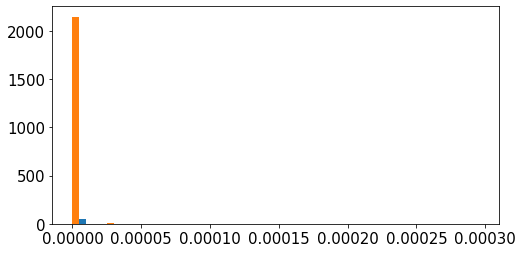

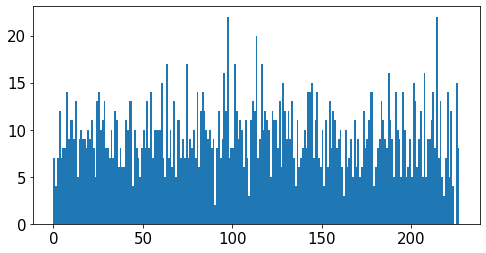

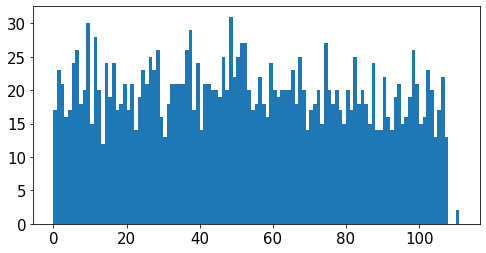

In [1311]:
plt.figure(figsize=(8,4))
plt.hist(G_program[~program_sucess], np.arange(0, 3e-4, 0.5e-5));
plt.hist(G[~program_sucess], np.arange(0, 3e-4, 0.5e-5));
plt.figure(figsize=(8,4))
plt.hist(np.where(~program_sucess)[0], np.arange(0, 228));
plt.figure(figsize=(8,4))
plt.hist(np.where(~program_sucess)[1], np.arange(0, 112));

# Calibrate Inference

In [29]:
inputs = []
labels = []
for i_batch, sample_batch in enumerate(test_dataloader):
    x_data, y_label = sample_batch
    x_data, y_label = model_lib.pre_processing(x_data, y_label, device, mfcc_cuda)
    inputs.append(x_data.numpy())
    labels.append(y_label.numpy())
inputs = np.concatenate(inputs, axis=1)
labels = np.hstack(labels)

In [8]:
# np.savez(DATA_PATH + 'inputs_4_5_trials', inputs=inputs, labels=labels)
tmp = np.load(DATA_PATH + 'inputs_4_5_trials.npz')
inputs = tmp['inputs']
labels = tmp['labels']

In [46]:
ITERATION = 5000 #inputs.shape[1]
time_step = 25
num_bits = 4
# input_sample = quantize_signed(inputs[time_step, :ITERATION, :], num_bits, relux)
# input_sample = nn_layers.quantize_signed(hx[block, :ITERATION, :], num_bits, relux)
input_sample = nn_layers.quantize_signed(hidden_state[-1, block, :ITERATION, :], num_bits, relux)
inputs_scale = quantize_signed_rescale(input_sample, num_bits, relux)

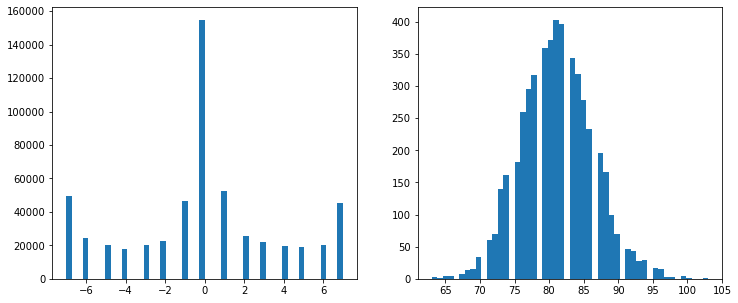

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(input_sample.flatten(), 50);
plt.subplot(122)
plt.hist(np.sum(input_sample != 0, axis=1), 50);

In [ ]:
# ITERATION = inputs.shape[1]
BATCH = 20
vpos = 0.56
vneg = 0.50
vreset_plus = 0.10 #0.17
vreset_minus = 0.01 #0.08
pulse_multiplier = 1
matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
spi.enable_single_core(dev, int(core_row), int(core_col))

# input_sample = np.floor(np.random.uniform(-7, 8, size=(ITERATION, 108)))
# inputs_scale = nn_layers.quantize_signed_rescale(input_sample, num_bits, relux)
actual_outputs = np.zeros([ITERATION, len(cols)])
expected_outputs = inputs_scale[:ITERATION].dot(weight) + bias
start = time.time()

for i in range(ITERATION//BATCH):
    actual_outputs[BATCH*i:BATCH*(i+1), :] = matmul.matmul(dev, input_sample[BATCH*i:BATCH*(i+1), :], rows, cols, 2, int(core_row), True, num_bits, True, int(core_col), pulse_multiplier=pulse_multiplier, prep=(i==0))

end = time.time()
print(end-start)
matmul.disable_inference(dev)

In [50]:
CYCLE = 50
BATCH = 20
vpos = 0.56
vneg = 0.50
vreset_plus = 0.10 #0.17
vreset_minus = 0.01 #0.08
pulse_multiplier = 20
matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
spi.enable_single_core(dev, core_row, core_col)

# matmul._setup_inference(dev, True, pulse_multiplier, run_all=False, partial_reset=True, col_addr=core_col, num_bits=num_bits-1)
# matmul._write_y_addr(dev, cols, row_addr=core_row, col_addr=core_col)

start = time.time()
# for i in range(CYCLE):
#     for b in range(ITERATION//BATCH):
#         matmul.send_inputs(dev, input_sample[BATCH*b:BATCH*(b+1), :], rows, 2, core_row, True, matmul._encode_input_signed,
#                            core_col, trigger=False, prep=(i==0) and (b==0), input_num_bits=num_bits)
#         for j in range(BATCH):
#             matmul._matmul_unsigned_helper_hw(dev, readout=False)
end = time.time()
print(end-start)
time.sleep(4532-(end-start))

actual_outputs = np.zeros([10, ITERATION, len(cols)])
expected_outputs = inputs_scale[:ITERATION].dot(weight) + bias
pulse_multiplier = 1
for c in range(10):
    for i in range(ITERATION//BATCH):
        actual_outputs[c, BATCH*i:BATCH*(i+1), :] = matmul.matmul(dev, input_sample[BATCH*i:BATCH*(i+1), :], rows, cols, 2, int(core_row), True, num_bits, True, int(core_col), pulse_multiplier=pulse_multiplier, prep=(i==0))
matmul.disable_inference(dev)

0.0


In [ ]:
# Multi-core

ITERATION = 5000
BATCH = 10
vpos = 0.72
vneg = 0.70
vreset_plus = 0.11 #0.17
vreset_minus = 0.03 #0.08
pulse_multiplier = 4
matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
spi.enable_single_col(dev, core_col)
# input_sample = np.floor(np.random.uniform(-2**(num_bits-1)+1, 2**(num_bits-1)-1, size=[ITERATION, len(rows)//2]))
# inputs_scale = nn.quantize_signed_rescale(input_sample[:ITERATION], num_bits, relux)

actual_outputs_0 = np.zeros([ITERATION, len(cols_0)])
actual_outputs_1 = np.zeros([ITERATION, len(cols_0)])
expected_outputs_0 = inputs_scale.dot(W_0)
expected_outputs_1 = inputs_scale.dot(W_1)
start = time.time()

for i in range(ITERATION//BATCH):
    input_batch = inputs_cal[BATCH*i:BATCH*(i+1), :]
    out_tmp = matmul.matmul(
        dev, [[input_batch], [input_batch]], [[rows_0], [rows_1]], [[cols_0], [cols_1]], [[False], [False]],
        [core_row_0, core_row_1], True, num_bits, True, [core_col_0], pulse_multiplier=pulse_multiplier, prep=(i==0))
    actual_outputs_0[BATCH*i:BATCH*(i+1), :] = out_tmp[0][0]
    actual_outputs_1[BATCH*i:BATCH*(i+1), :] = out_tmp[1][0]

end = time.time()
print(end-start)
matmul.disable_inference(dev)

In [1232]:
actual_outputs = actual_outputs_0
expected_outputs = expected_outputs_0

In [1342]:
actual_outputs = (actual_outputs - intercept_hidden[idx-16]) / slope_hidden[idx-16]

In [51]:
slope = np.zeros(W.shape[1])
intercept = np.zeros(W.shape[1])
# errors = np.zeros(W.shape[1])
for c in range(W.shape[1]):
    p, res, _, _, _ = np.polyfit(expected_outputs[:, c], actual_outputs[0, :,c], 1, full=True)
    slope[c] = p[0]
    intercept[c] = p[1]
#     actual_outputs[:, c] = (actual_outputs[:, c] - p[1]) / p[0]
#     errors[c] = np.sqrt(res[0]) / p[0]
# print(errors.mean())
print(slope.mean())

4.856787389874488


In [52]:
errors = np.zeros([10, W.shape[1]])
actual_outputs_shift = (actual_outputs - intercept) / slope
np.linalg.norm(actual_outputs_shift - expected_outputs)

99.63335226432858

In [284]:
# output = np.zeros([n_msb, ITERATION, len(word_list)], dtype=np.float32)
output[block, :, :] = actual_outputs

In [767]:
expected_outputs = fake_quant_signed(expected_outputs, quant_actMVM, out_clip)
actual_outputs = fake_quant_signed(actual_outputs, quant_actMVM, out_clip)

In [285]:
np.savez(DATA_PATH + 'fc_output_3', output=output, core_row_list=core_row_list_fc, core_col_list=core_col_list_fc, 
         rows_list=rows_list_fc, cols_list=cols_list_fc)

In [28]:
# expected_outputs = inputs_scale.dot(W)
expected_outputs_all = expected_outputs
actual_outputs_all = actual_outputs

In [193]:
expected_outputs = expected_outputs_all
actual_outputs = actual_outputs_all

(0, 0.14622743663086915)
(1, 0.12151232254859763)
(2, 0.24896307495189599)
(3, 0.17827780389936818)
(4, 0.14755795344647435)
(5, 0.16569723527942576)
(6, 0.11997314433476372)
(7, 0.1228213881530605)
(8, 0.11560203950782688)
(9, 0.12737645752273297)
(10, 0.11569418028296335)
(11, 0.15979761523241146)


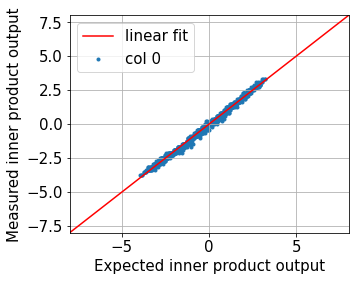

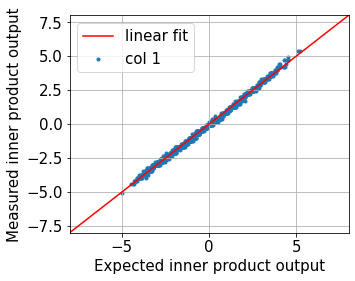

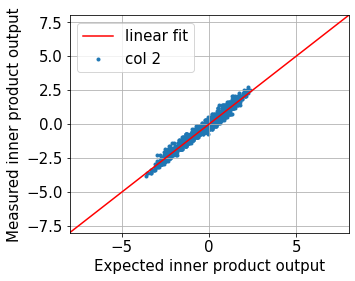

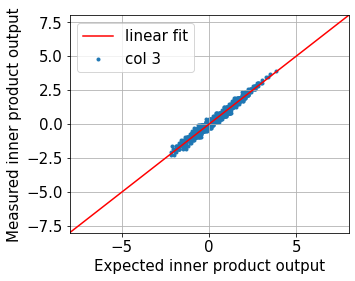

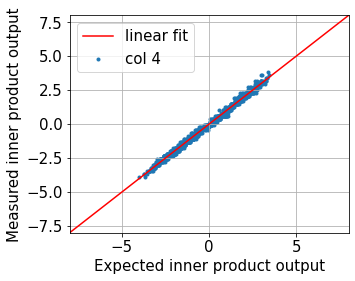

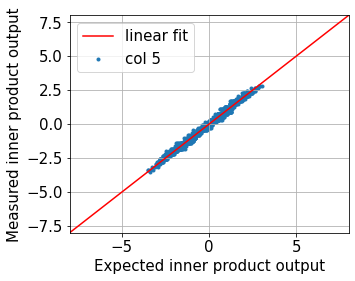

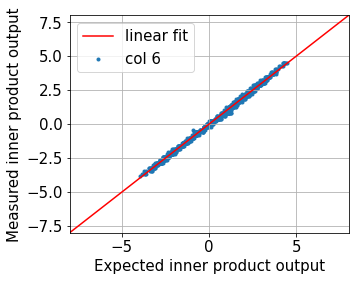

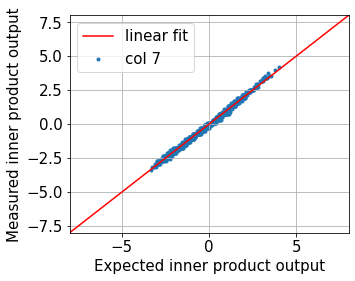

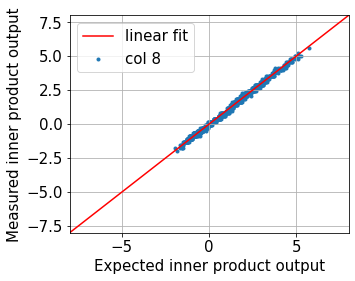

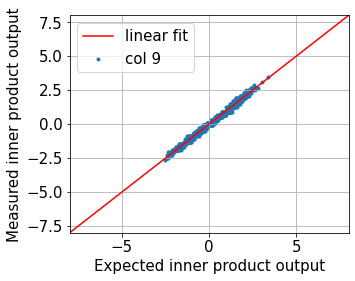

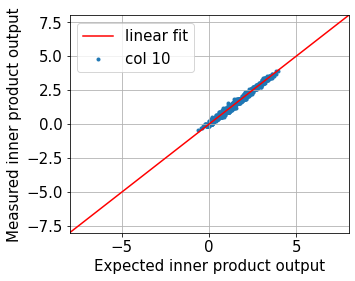

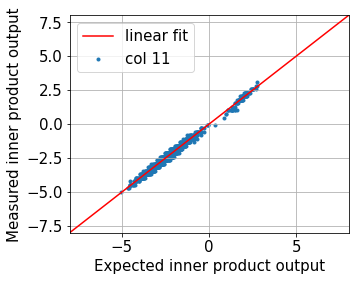

In [29]:
for c in range(W.shape[1]):
    expected_outputs = expected_outputs_all[:, c]
    actual_outputs = actual_outputs_all[:, c]

#     expected_outputs = expected_outputs / np.linalg.norm(expected_outputs) * np.sqrt(expected_outputs.size)
    p, res, _, _, _ = np.polyfit(expected_outputs.flatten(), actual_outputs.flatten(), 1, full=True)
    y_fit = np.poly1d(p)
    std = np.sqrt(res/(expected_outputs.size-1))
    x = np.arange(-40, 40, 0.1)

    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(5,4))
    plt.scatter(expected_outputs, actual_outputs/p[0], label='col %d' % c, marker='.')
    plt.plot(x, y_fit(x)/p[0], 'r', label='linear fit')
#     plt.plot(x, x, 'r', label='linear fit')
    plt.grid()
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.xlabel('Expected inner product output')
    plt.ylabel('Measured inner product output')
    plt.legend()


#     print(p[0])
    print((c, std[0]/p[0]))

In [129]:
# Calibrate reset voltage
linear = lambda x, k: x*k

mask_pos = expected_outputs > 0
mask_neg = ~mask_pos

p1, _, _, _, _ = np.polyfit(expected_outputs[mask_pos].flatten(), actual_outputs[mask_pos].flatten(), 1, full=True)
y_fit_1 = np.poly1d(p1)
x1 = np.linspace(0, 40, 10)

p2, _, _, _, _ = np.polyfit(expected_outputs[mask_neg].flatten(), actual_outputs[mask_neg].flatten(), 1, full=True)
y_fit_2 = np.poly1d(p2)
x2 = np.linspace(-40, 0, 10)

# plt.figure(figsize=(10,8))
# plt.rcParams.update({'font.size': 15})
# ax = plt.subplot(111)
# plt.scatter(expected_outputs, actual_outputs, label='measured output', marker='.')
# plt.plot(x1, y_fit_1(x1), 'r', label='linear fit pos')
# plt.plot(x2, y_fit_2(x2), 'y', label='linear fit neg')
# plt.grid()
# plt.xlim(-5, 5)
# plt.ylim(-20, 20)
# plt.xlabel('Expected inner product output')
# plt.ylabel('Measured inner product output')
# plt.legend()


print(p1[0])
print(p2[0])

1.0037688236275584
0.9959526593584721


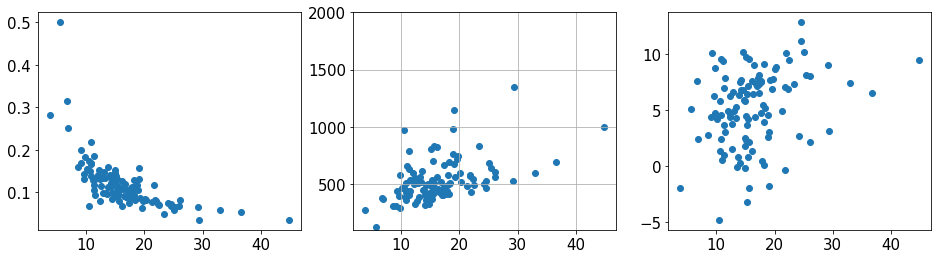

In [1153]:
plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.scatter(np.abs(W).sum(axis=0), slope)
plt.subplot(132)
plt.scatter(np.abs(W).sum(axis=0), errors);
plt.ylim(100, 2000)
plt.grid()
plt.subplot(133)
plt.scatter(np.abs(W).sum(axis=0), intercept);

# Find the optimal voltage

In [1518]:
# Find the optimal voltage for each core
CALIBRATE = True
ITERATION = input_sample.shape[0]
BATCH = 10
vpos_list = np.arange(0.70, 0.72, 0.005)
vneg = 0.70
vreset_plus = 0.10
vreset_minus = 0.01
pulse_multiplier = 3

slope = np.zeros([16, len(vpos_list), hidden])
intercept = np.zeros([16, len(vpos_list), hidden])
errors = np.zeros([16, len(vpos_list), hidden])

for block in range(4):
    for gate in range(4):
        weight = weight_hh_clip[block, :, gate*hidden:(gate+1)*hidden]
        bias = bias_hh_clip[block, 0, gate*hidden:(gate+1)*hidden]
        relux = a11[block]
        c = block * 4 + gate
        core_row = int(core_row_list[c+16])
        core_col = int(core_col_list[c+16])
        spi.enable_single_core(dev, core_row, core_col)
        if CALIBRATE:
            vpos_list = np.arange(best_voltage[c]-0.01, best_voltage[c]+0.01, 0.005)
        for v, vpos in enumerate(vpos_list):
            matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
            actual_outputs = np.zeros([ITERATION, hidden])
            expected_outputs = inputs_scale.dot(weight) + bias

            for i in range(ITERATION//BATCH):
                actual_outputs[BATCH*i:BATCH*(i+1), :] = matmul.matmul(
                    dev, input_sample[BATCH*i:BATCH*(i+1), :], rows_list[c+16], cols_list[c+16], 2, core_row, True, num_bits, True, core_col, pulse_multiplier=pulse_multiplier, prep=(i==0))


            for j in range(hidden):
                p, res, _, _, _ = np.polyfit(expected_outputs[:, j], actual_outputs[:, j], 1, full=True)
                slope[c, v, j] = p[0]
                intercept[c, v, j] = p[1]
                errors[c, v, j] = np.sqrt(res[0]) / p[0]
                if p[0] < 0:
                    print('negative slope %d, %d core, %d column' % (core_row, core_col, cols_list[c+16][j]))
                    errors[c, v, j] = np.inf

            print('Finished row %d, voltage %f' % (c, vpos))

matmul.disable_inference(dev)

Finished row 0, voltage 0.760000
Finished row 0, voltage 0.765000
Finished row 0, voltage 0.770000
Finished row 0, voltage 0.775000
Finished row 0, voltage 0.780000
Finished row 1, voltage 0.800000
Finished row 1, voltage 0.805000
Finished row 1, voltage 0.810000
Finished row 1, voltage 0.815000
Finished row 1, voltage 0.820000
Finished row 2, voltage 0.805000
Finished row 2, voltage 0.810000
Finished row 2, voltage 0.815000
Finished row 2, voltage 0.820000
Finished row 2, voltage 0.825000
Finished row 3, voltage 0.825000
Finished row 3, voltage 0.830000
Finished row 3, voltage 0.835000
Finished row 3, voltage 0.840000
Finished row 3, voltage 0.845000
Finished row 4, voltage 0.825000
Finished row 4, voltage 0.830000
Finished row 4, voltage 0.835000
Finished row 4, voltage 0.840000
Finished row 4, voltage 0.845000
Finished row 5, voltage 0.820000
Finished row 5, voltage 0.825000
Finished row 5, voltage 0.830000
Finished row 5, voltage 0.835000
Finished row 5, voltage 0.840000
Finished r

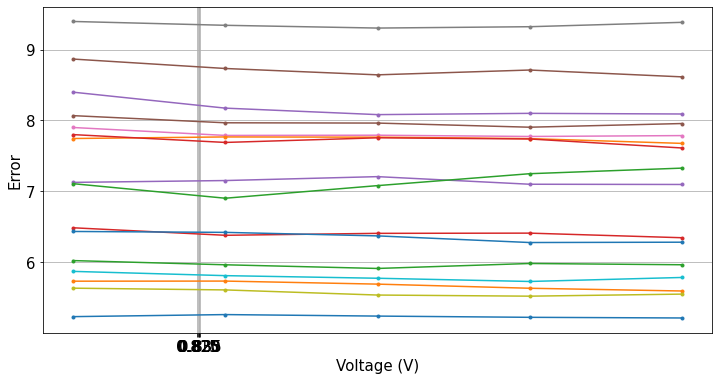

In [1429]:
# vpos_list = np.arange(0.70, 0.90, 0.01)
plt.figure(figsize=(12,6))
for c in range(16):
    plt.plot(np.arange(5), errors.mean(axis=2)[c, :], marker='.', label='%d' % c)
plt.xlabel('Voltage (V)')
plt.ylabel('Error')
plt.xticks(vpos_list)
# plt.xlim(0.715, 0.885)
# plt.ylim(5, 50)
plt.grid()
# plt.legend(loc=1)

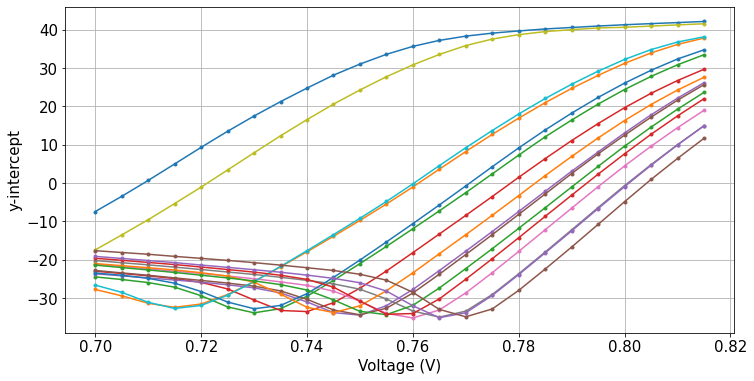

In [1172]:
plt.figure(figsize=(12,6))
for c in range(16):
    plt.plot(vpos_list, intercept.mean(axis=2)[c, :], marker='.', label='%d' % c)
plt.xlabel('Voltage (V)')
plt.ylabel('y-intercept')
# plt.ylim(200, 800)
plt.grid()
# plt.legend()

In [1519]:
np.savez(DATA_PATH + 'core_voltage_opt_hidden_10_calibrate', error=errors, slope=slope, intercept=intercept, pulse_multiplier=pulse_multiplier, vpos=best_voltage, vneg=vneg)

In [19]:
tmp = np.load(DATA_PATH + 'core_voltage_opt_hidden_10_calibrate.npz')
errors = tmp['error']
pulse_multiplier = tmp['pulse_multiplier']
best_voltage = tmp['vpos']
print(pulse_multiplier)

3


In [20]:
CALIBRATE = True
best_voltage_idx = np.argmin(errors.mean(axis=2), axis=1)
if CALIBRATE:
    print(best_voltage)
    best_voltage_old = best_voltage
    best_voltage = best_voltage_old + 0.005 * (best_voltage_idx - 2)
else:
    best_voltage = vpos_list[best_voltage_idx]
print(best_voltage)

[0.77  0.81  0.815 0.835 0.835 0.83  0.825 0.845 0.795 0.82  0.83  0.835
 0.83  0.83  0.835 0.84 ]
[0.775 0.82  0.825 0.835 0.835 0.825 0.835 0.835 0.785 0.82  0.825 0.83
 0.83  0.83  0.835 0.84 ]


In [1520]:
error_core_10 = errors.mean(axis=2).min(axis=1)

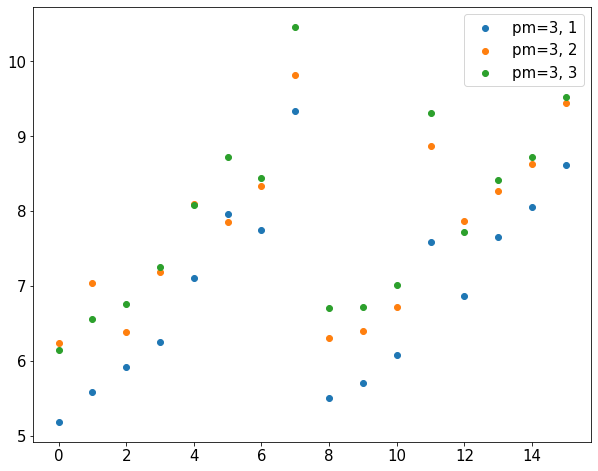

In [1522]:
# plt.scatter(np.arange(16), np.min(errors_6.mean(axis=2), axis=1), label='pm=4, 1')

plt.scatter(np.arange(16), error_core_7, label='pm=3, 1')
plt.scatter(np.arange(16),  error_core_9, label='pm=3, 2')
plt.scatter(np.arange(16), error_core_10, label='pm=3, 3')
plt.legend()

In [1387]:
slope_hidden = np.zeros([slope.shape[0], hidden])
intercept_hidden = np.zeros([slope.shape[0], hidden])
for core in range(slope.shape[0]):
    slope_hidden[core, :] = slope[core, best_voltage_idx[core], :]
    intercept_hidden[core, :] = intercept[core, best_voltage_idx[core], :]

# Inference

In [1087]:
ITERATION = inputs.shape[1]
num_block = 4
num_gate = 4
num_time_step = 50
hidden_state_ih_tmp = np.zeros([num_time_step, ITERATION, hidden], dtype=np.float32)
# hidden_state_ih = np.zeros([num_time_step, num_block, ITERATION, hidden*num_gate], dtype=np.float32)

for block in [2]: #range(num_block):
    for gate in [0]: #range(num_gate):
        weight = weight_ih_clip[block, :, gate*hidden:(gate+1)*hidden]
        bias = bias_ih_clip[block, 0, gate*hidden:(gate+1)*hidden]
        relux = a1[block]
        c = block * 4 + gate
        core_row = int(core_row_list[c])
        core_col = int(core_col_list[c])
        spi.enable_single_core(dev, core_row, core_col)
        vpos = best_voltage[c]
        matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
        for time_step in range(num_time_step):
            input_sample = nn_layers.quantize_signed(inputs[time_step], num_bits, relux)
#             inputs_scale = nn_layers.quantize_signed_rescale(input_sample, num_bits, relux)
            actual_outputs = np.zeros([ITERATION, hidden])
#             expected_outputs = inputs_scale.dot(weight) + bias
            for i in range(ITERATION//BATCH):
                actual_outputs[BATCH*i:BATCH*(i+1), :] = matmul.matmul(
                    dev, input_sample[BATCH*i:BATCH*(i+1), :], rows_list[c], cols_list[c], 2, core_row, True, num_bits, True, core_col, pulse_multiplier=4, prep=(i==0))
                
#             for j in range(hidden):
#                 p, res, _, _, _ = np.polyfit(expected_outputs[:, j], actual_outputs[:, j], 1, full=True)
#                 if p[0] < 0:
#                     print('negative slope block %d, gate %d, column %d, time step %d' % (block, gate, cols_list[c][j], time_step))
#                 actual_outputs[:, j] = (actual_outputs[:, j] - p[1]) / p[0]
#             actual_outputs = (actual_outputs - intercepts[c]) / slopes[c]
            hidden_state_ih_tmp[time_step] = actual_outputs
#             hidden_state_ih[time_step, block, :, hidden*gate:hidden*(gate+1)] = actual_outputs
            print('Finished block %d, gate %d, time step %d' % (block, gate, time_step))
matmul.disable_inference(dev)

Finished block 2, gate 0, time step 0
Finished block 2, gate 0, time step 1
Finished block 2, gate 0, time step 2
Finished block 2, gate 0, time step 3
Finished block 2, gate 0, time step 4
Finished block 2, gate 0, time step 5
Finished block 2, gate 0, time step 6
Finished block 2, gate 0, time step 7
Finished block 2, gate 0, time step 8
Finished block 2, gate 0, time step 9
Finished block 2, gate 0, time step 10
Finished block 2, gate 0, time step 11
Finished block 2, gate 0, time step 12
Finished block 2, gate 0, time step 13
Finished block 2, gate 0, time step 14
Finished block 2, gate 0, time step 15
Finished block 2, gate 0, time step 16
Finished block 2, gate 0, time step 17
Finished block 2, gate 0, time step 18
Finished block 2, gate 0, time step 19
Finished block 2, gate 0, time step 20
Finished block 2, gate 0, time step 21
Finished block 2, gate 0, time step 22
Finished block 2, gate 0, time step 23
Finished block 2, gate 0, time step 24
Finished block 2, gate 0, time step

In [863]:
np.savez(DATA_PATH + 'hidden_state_ih_7st_trial', hidden_state_ih=hidden_state_ih, core_row_list=core_row_list, core_col_list=core_col_list,
         rows_list=rows_list, cols_list=cols_list, best_voltage=best_voltage, pulse_multiplier=pulse_multiplier)

In [942]:
time_step = 15
slopes = np.zeros([num_block, num_gate, hidden])
intercepts = np.zeros([num_block, num_gate, hidden])
hidden_state_ih_shift = np.zeros_like(hidden_state_ih)
for block in range(num_block):
    for gate in range(num_gate):
        input_quantized = quantize_signed(inputs[time_step, :, :], quant_inp, a1[block])
        input_scale = quantize_signed_rescale(input_quantized, quant_inp, a1[block])
        expected_outputs = input_scale.dot(weight_ih_clip[block, :, hidden*gate:hidden*(gate+1)]) + bias_ih_clip[block, 0, hidden*gate:hidden*(gate+1)]
        actual_outputs = hidden_state_ih[time_step, block, :, hidden*gate:hidden*(gate+1)]
        for j in range(hidden):
            p, res, _, _, _ = np.polyfit(expected_outputs[:, j], actual_outputs[:, j], 1, full=True)
            slopes[block, gate, j] = p[0]
            intercepts[block, gate, j] = p[1]
        hidden_state_ih_shift[:, block, :, hidden*gate:hidden*(gate+1)] = (hidden_state_ih[:, block, :, hidden*gate:hidden*(gate+1)] - intercepts[block, gate, :]) / slopes[block, gate, :]

In [1088]:
time_step = 15
# block = 3
# gate = 3

slope = np.zeros(hidden, dtype=np.float32)
intercept = np.zeros(hidden, dtype=np.float32)

input_quantized = quantize_signed(inputs[time_step, :, :], quant_inp, a1[block])
input_scale = quantize_signed_rescale(input_quantized, quant_inp, a1[block])
expected_outputs = input_scale.dot(weight_ih_clip[block, :, hidden*gate:hidden*(gate+1)]) + bias_ih_clip[block, 0, hidden*gate:hidden*(gate+1)]
actual_outputs = hidden_state_ih_tmp[time_step]
for j in range(hidden):
    p, res, _, _, _ = np.polyfit(expected_outputs[:, j], actual_outputs[:, j], 1, full=True)
    slope[j] = p[0]
    intercept[j] = p[1]
hidden_state_ih_shift_tmp = (hidden_state_ih_tmp - intercept) / slope

In [1098]:
np.save(DATA_PATH + 'hidden_state_ih_shift', hidden_state_ih_shift)

In [934]:
tmp = np.load(DATA_PATH + 'hidden_state_ih_6st_trial.npz')
hidden_state_ih = tmp['hidden_state_ih']

In [639]:
hidden_state_ih = np.transpose(hidden_state_ih, [0, 1, 3, 2, 4]).reshape([num_time_step, n_msb, ITERATION, hidden*num_gate])

In [15]:
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

In [62]:
# Calibrate for the slope and intercept for each core
ITERATION = 1000
BATCH = 10

slope_hidden = np.zeros([16, hidden])
intercept_hidden = np.zeros([16, hidden])
error_hidden = np.zeros([16, hidden])

for block in range(4):
    for gate in range(4):
        weight = weight_hh_clip[block, :, gate*hidden:(gate+1)*hidden]
        bias = bias_hh_clip[block, 0, gate*hidden:(gate+1)*hidden]
        relux = a11[block]
        c = block * 4 + gate
        core_row = int(core_row_list[c+16])
        core_col = int(core_col_list[c+16])
        spi.enable_single_core(dev, core_row, core_col)
        matmul.dac_setup(dev, best_voltage[c], vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
        
        input_sample = nn_layers.quantize_signed(hx[block, :ITERATION, :], num_bits, relux)
        inputs_scale = quantize_signed_rescale(input_sample, num_bits, relux)
        actual_outputs = np.zeros([ITERATION, hidden])
        expected_outputs = inputs_scale.dot(weight) + bias

        for i in range(ITERATION//BATCH):
            actual_outputs[BATCH*i:BATCH*(i+1), :] = matmul.matmul(
                dev, input_sample[BATCH*i:BATCH*(i+1), :], rows_list[c+16], cols_list[c+16], 2, core_row, True, num_bits, True, core_col,
                pulse_multiplier=3, prep=(i==0))

        for j in range(hidden):
            p, res, _, _, _ = np.polyfit(expected_outputs[:, j], actual_outputs[:, j], 1, full=True)
            slope_hidden[c, j] = p[0]
            intercept_hidden[c, j] = p[1]
            error_hidden[c, j] = np.sqrt(res[0]) / p[0]
            if p[0] < 0:
                print('negative slope %d, %d core, %d column' % (core_row, core_col, cols_list[c+16][j]))
                errors[c, j] = np.inf

        print('Finished core %d' % c)

matmul.disable_inference(dev)

Finished core 0
Finished core 1
Finished core 2
Finished core 3
Finished core 4
Finished core 5
Finished core 6
Finished core 7
Finished core 8
Finished core 9
Finished core 10
Finished core 11
Finished core 12
Finished core 13
Finished core 14
Finished core 15


In [1595]:
print(error_hidden.mean(axis=1))

[5.44315023 5.97204517 5.34936298 6.17328738 6.63038425 7.46688765
 6.8686036  8.43433138 5.56734018 5.73986969 5.94560391 7.24289168
 6.41481545 7.02738668 7.210861   7.66749166]


In [63]:
print(error_hidden.mean(axis=1))

[5.46973372 6.11150934 5.68888258 6.48329839 6.99070756 7.74809505
 7.23775334 8.94032734 5.61145273 5.72702776 6.1096607  7.41534104
 6.78220794 7.43941787 7.7945446  8.43829744]


In [71]:
# best_voltage = best_voltage_hidden
# pulse_multiplier = 3
ITERATION = inputs.shape[1]
hidden_state = np.zeros([num_time_step, n_msb, ITERATION, hidden], dtype=np.float32)
hidden_state_hh = np.zeros([num_time_step, n_msb, ITERATION, num_gate*hidden], dtype=np.float32)

gates = fake_quant_signed(fake_quant_signed(hidden_state_ih_shift[0], quant_actMVM, a12), quant_actNM, a14)
i, j, f, o = np.split(gates, 4, axis=2)

forget_gate_out = fake_quant_signed(sigmoid(f), quant_actNM, a3)
input_gate_out = fake_quant_signed(sigmoid(i), quant_actNM, a4)
activation_out = fake_quant_signed(np.tanh(j), quant_actNM, a5)
output_gate_out = fake_quant_signed(sigmoid(o), quant_actNM, a6)

activated_input = fake_quant_signed(input_gate_out * activation_out, quant_actNM, a8)
cx = fake_quant_signed(activated_input, quant_actNM, a9)
activated_cell = fake_quant_signed(np.tanh(cx), quant_actNM, a10)
hx = fake_quant_signed(activated_cell * output_gate_out, quant_actNM, a11)
hidden_state[0] = hx

In [74]:

for time_step in range(1, num_time_step):
#     hx = hidden_state[time_step-1]
    part1 = hidden_state_ih_shift[time_step]
    part2 = np.zeros([n_msb, ITERATION, num_gate*hidden], dtype=np.float32)
    for block in range(n_msb):
        relux = a11[block, 0, 0]
        hidden_quantized = nn_layers.quantize_signed(hx[block], num_bits, relux)
#         hidden_scale = nn_layers.quantize_signed_rescale(hidden_quantized, num_bits, relux)
        for gate in range(num_gate):
#             weight = weight_hh_clip[block, :, gate*hidden:(gate+1)*hidden]
#             bias = bias_hh_clip[block, 0, gate*hidden:(gate+1)*hidden]
            ch = block * 4 + gate
            c = ch + 16
            core_row = int(core_row_list[c])
            core_col = int(core_col_list[c])
            spi.enable_single_core(dev, core_row, core_col)
            vpos = best_voltage[ch]
            matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
            actual_outputs = np.zeros([ITERATION, hidden])
#             expected_outputs = hidden_scale.dot(weight) + bias
            for i in range(ITERATION//BATCH):
                actual_outputs[BATCH*i:BATCH*(i+1), :] = matmul.matmul(
                    dev, hidden_quantized[BATCH*i:BATCH*(i+1), :], rows_list[c], cols_list[c], 2, core_row,
                    True, num_bits, True, core_col, pulse_multiplier=pulse_multiplier, prep=(i==0))
                
#             for j in range(hidden):
#                 p, res, _, _, _ = np.polyfit(expected_outputs[:, j], actual_outputs[:, j], 1, full=True)
#                 if p[0] < 0:
#                     print('negative slope block %d, gate %d, column %d, time step %d' % (block, gate, cols_list[c][j], time_step))
#                 actual_outputs[:, j] = (actual_outputs[:, j] - p[1]) / p[0]
            actual_outputs = (actual_outputs - intercept_hidden[ch, :]) / slope_hidden[ch, :]
            part2[block, :, gate*hidden:(gate+1)*hidden] = actual_outputs
            print('Finished block %d, gate %d, time step %d' % (block, gate, time_step))
    hidden_state_hh[time_step] = part2
    
    gates = fake_quant_signed(fake_quant_signed(part1, quant_actMVM, a12) + fake_quant_signed(part2, quant_actMVM, a13), quant_actNM, a14)
    i, j, f, o = np.split(gates, 4, axis=2)
    forget_gate_out = fake_quant_signed(sigmoid(f), quant_actNM, a3)
    input_gate_out = fake_quant_signed(sigmoid(i), quant_actNM, a4)
    activation_out = fake_quant_signed(np.tanh(j), quant_actNM, a5)
    output_gate_out = fake_quant_signed(sigmoid(o), quant_actNM, a6)
    
    gated_cell = fake_quant_signed(cx * forget_gate_out, quant_actNM, a7)
    activated_input = fake_quant_signed(input_gate_out * activation_out, quant_actNM, a8)
    cx = fake_quant_signed(gated_cell + activated_input, quant_actNM, a9)
    activated_cell = fake_quant_signed(np.tanh(cx), quant_actNM, a10)
    hx = fake_quant_signed(activated_cell * output_gate_out, quant_actNM, a11)
    hidden_state[time_step] = hx
    print('Finished time step %d' % time_step)
matmul.disable_inference(dev)

Finished block 0, gate 0, time step 1
Finished block 0, gate 1, time step 1
Finished block 0, gate 2, time step 1
Finished block 0, gate 3, time step 1
Finished block 1, gate 0, time step 1
Finished block 1, gate 1, time step 1
Finished block 1, gate 2, time step 1
Finished block 1, gate 3, time step 1
Finished block 2, gate 0, time step 1
Finished block 2, gate 1, time step 1
Finished block 2, gate 2, time step 1
Finished block 2, gate 3, time step 1
Finished block 3, gate 0, time step 1
Finished block 3, gate 1, time step 1
Finished block 3, gate 2, time step 1
Finished block 3, gate 3, time step 1
Finished time step 1
Finished block 0, gate 0, time step 2
Finished block 0, gate 1, time step 2
Finished block 0, gate 2, time step 2
Finished block 0, gate 3, time step 2
Finished block 1, gate 0, time step 2
Finished block 1, gate 1, time step 2
Finished block 1, gate 2, time step 2
Finished block 1, gate 3, time step 2
Finished block 2, gate 0, time step 2
Finished block 2, gate 1, tim

Finished time step 13
Finished block 0, gate 0, time step 14
Finished block 0, gate 1, time step 14
Finished block 0, gate 2, time step 14
Finished block 0, gate 3, time step 14
Finished block 1, gate 0, time step 14
Finished block 1, gate 1, time step 14
Finished block 1, gate 2, time step 14
Finished block 1, gate 3, time step 14
Finished block 2, gate 0, time step 14
Finished block 2, gate 1, time step 14
Finished block 2, gate 2, time step 14
Finished block 2, gate 3, time step 14
Finished block 3, gate 0, time step 14
Finished block 3, gate 1, time step 14
Finished block 3, gate 2, time step 14
Finished block 3, gate 3, time step 14
Finished time step 14
Finished block 0, gate 0, time step 15
Finished block 0, gate 1, time step 15
Finished block 0, gate 2, time step 15
Finished block 0, gate 3, time step 15
Finished block 1, gate 0, time step 15
Finished block 1, gate 1, time step 15
Finished block 1, gate 2, time step 15
Finished block 1, gate 3, time step 15
Finished block 2, ga

Finished block 2, gate 3, time step 26
Finished block 3, gate 0, time step 26
Finished block 3, gate 1, time step 26
Finished block 3, gate 2, time step 26
Finished block 3, gate 3, time step 26
Finished time step 26
Finished block 0, gate 0, time step 27
Finished block 0, gate 1, time step 27
Finished block 0, gate 2, time step 27
Finished block 0, gate 3, time step 27
Finished block 1, gate 0, time step 27
Finished block 1, gate 1, time step 27
Finished block 1, gate 2, time step 27
Finished block 1, gate 3, time step 27
Finished block 2, gate 0, time step 27
Finished block 2, gate 1, time step 27
Finished block 2, gate 2, time step 27
Finished block 2, gate 3, time step 27
Finished block 3, gate 0, time step 27
Finished block 3, gate 1, time step 27
Finished block 3, gate 2, time step 27
Finished block 3, gate 3, time step 27
Finished time step 27
Finished block 0, gate 0, time step 28
Finished block 0, gate 1, time step 28
Finished block 0, gate 2, time step 28
Finished block 0, ga

Finished block 1, gate 2, time step 39
Finished block 1, gate 3, time step 39
Finished block 2, gate 0, time step 39
Finished block 2, gate 1, time step 39
Finished block 2, gate 2, time step 39
Finished block 2, gate 3, time step 39
Finished block 3, gate 0, time step 39
Finished block 3, gate 1, time step 39
Finished block 3, gate 2, time step 39
Finished block 3, gate 3, time step 39
Finished time step 39
Finished block 0, gate 0, time step 40
Finished block 0, gate 1, time step 40
Finished block 0, gate 2, time step 40
Finished block 0, gate 3, time step 40
Finished block 1, gate 0, time step 40
Finished block 1, gate 1, time step 40
Finished block 1, gate 2, time step 40
Finished block 1, gate 3, time step 40
Finished block 2, gate 0, time step 40
Finished block 2, gate 1, time step 40
Finished block 2, gate 2, time step 40
Finished block 2, gate 3, time step 40
Finished block 3, gate 0, time step 40
Finished block 3, gate 1, time step 40
Finished block 3, gate 2, time step 40
Fin

In [76]:
np.savez(DATA_PATH + 'hidden_state_8th_trial', hidden_state=hidden_state, hidden_state_hh=hidden_state_hh, core_row_list=core_row_list, core_col_list=core_col_list,
         rows_list=rows_list, cols_list=cols_list, best_voltage=best_voltage, pulse_multiplier=pulse_multiplier)

In [78]:
tmp = np.load(DATA_PATH + 'hidden_state_7th_trial.npz', allow_pickle=True)
core_row_list = tmp['core_row_list']
core_col_list = tmp['core_col_list']
rows_list = tmp['rows_list']
cols_list = tmp['cols_list']
pulse_multiplier = tmp['pulse_multiplier']
hidden_state = tmp['hidden_state']
hidden_state_hh = tmp['hidden_state_hh']

In [44]:
hidden_state_ih_shift = np.load(DATA_PATH + 'hidden_state_ih_shift.npy')

# single core vs. multi-core

In [1321]:
# Compare single core vs. multi-core accuracy
ITERATION = 5000
BATCH = 8
vpos = 0.74
vneg = 0.70
vreset_plus = 0.12
vreset_minus = 0.03
pulse_multiplier = 4
core_para = [1, 2, 4, 8]

bias = 7 * np.ones([ITERATION, num_bias])
inputs_cal = np.hstack([input_sample[:ITERATION, :], bias])
inputs_scale = nn.quantize_signed_rescale(inputs_cal, num_bits, relux)

expected_outputs = np.zeros([8, ITERATION, len(cols_list[0])])
for c in range(8):
    expected_outputs[c, :, :] = inputs_scale.dot(W_list[c])

slope = np.zeros([len(core_para), 8, W_0.shape[1]])
intercept = np.zeros([len(core_para), 8, W_0.shape[1]])
errors = np.zeros([len(core_para), 8, W_0.shape[1]])

matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
spi.enable_single_col(dev, core_col_list[0])

for c, num_core in enumerate(core_para):
    num_step = 8 // num_core
    for s in range(num_step):
        rows = []
        cols = []
        core_row = []
        for n in range(num_core):
            rows.append([rows_list[s*num_core+n]])
            cols.append([cols_list[s*num_core+n]])
            core_row.append(core_row_list[s*num_core+n])
        actual_outputs = np.zeros([num_core, ITERATION, len(cols_list[0])])
        for i in range(ITERATION//BATCH):
            input_batch = inputs_cal[BATCH*i:BATCH*(i+1), :]
            out_tmp = matmul.matmul(
                dev, [[input_batch]]*num_core, rows, cols, [[False]]*num_core, core_row, True, num_bits, True,
                [core_col_list[0]], pulse_multiplier=pulse_multiplier, prep=(i==0))
            actual_outputs[:, BATCH*i:BATCH*(i+1), :] = np.array(out_tmp)[:, 0, :, :]
        for n in range(num_core):
            for j in range(W_0.shape[1]):
                p, res, _, _, _ = np.polyfit(expected_outputs[s*num_core+n, :, j], actual_outputs[n, :, j], 1, full=True)
#                 assert p[0] > 0
                slope[c, s*num_core+n, j] = p[0]
                intercept[c, s*num_core+n, j] = p[1]
                errors[c, s*num_core+n, j] = np.sqrt(res[0]) / p[0]
        print('Finished %d-core parallel, step %d' % (num_core, s))

Finished 1-core parallel, step 0
Finished 1-core parallel, step 1
Finished 1-core parallel, step 2
Finished 1-core parallel, step 3
Finished 1-core parallel, step 4
Finished 1-core parallel, step 5
Finished 1-core parallel, step 6
Finished 1-core parallel, step 7
Finished 2-core parallel, step 0
Finished 2-core parallel, step 1
Finished 2-core parallel, step 2
Finished 2-core parallel, step 3
Finished 4-core parallel, step 0
Finished 4-core parallel, step 1
Finished 8-core parallel, step 0


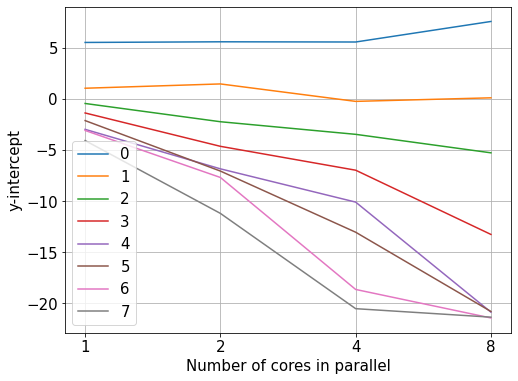

In [1338]:
# plt.figure(figsize=(8,6))
fig1, ax1 = plt.subplots(figsize=(8,6))
for c in range(8):
    plt.plot(core_para, intercept.mean(axis=2)[:, c], label='%d' % c)
plt.xlabel('Number of cores in parallel')
plt.ylabel('y-intercept')

ax1.set_xscale('log')
ax1.set_xticks(core_para)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.minorticks_off()
# plt.ylim(0, 2000)
plt.grid()
plt.legend()

(0, 970.0906283895364)
(1, 1016.6111734352013)
(2, 394.8665593152153)
(3, 440.2950412988515)
(4, 506.7026763805477)
(5, 537.9066001711452)
(6, 856.9674819904535)
(7, 559.6058146685477)
(8, 622.6997435533151)
(9, 634.9425431519518)
(10, 750.4097988842976)
(11, 1389.5114463585644)
(12, 1252.5309042056992)
(13, 2801.9350828541133)
(14, 2399.1664529748573)
(15, -589.6057085831333)
(16, 687.3901611422558)
(17, 643.2663822759353)
(18, 839.415405384459)
(19, 861.5281441290988)
(20, 860.7561972949457)
(21, 765.5848739026453)
(22, 1075.3593209002374)

C:\Users\Weier Wan\.conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()



(23, 997.7253615186231)
(24, 1283.2208389332804)
(25, 1331.0154018269102)
(26, 1119.797540926948)
(27, 944.8339844446889)
(28, 863.2168100582978)
(29, 1030.0430327035392)
(30, 1475.0284847369205)
(31, 905.5530489550348)
(32, 998.5207485520652)
(33, 958.0007038162561)
(34, 562.6076133968724)
(35, 986.5823934089664)
(36, 837.9849408970723)
(37, 480.2035838458048)
(38, 663.8356838736242)
(39, 823.8188874444941)
(40, 700.9741884644208)
(41, 502.08313917805697)
(42, 640.6648671356403)
(43, 5661.315839998276)
(44, 657.8190144162628)
(45, 899.0314742020046)
(46, 937.5450874460217)
(47, 909.8859870598324)
(48, 1362.3057900893923)
(49, 475.85012050665637)
(50, 1113.2202926434086)
(51, 1138.8267485204371)
(52, 1193.1370529964888)
(53, 697.7621116997778)
(54, 1125.8578175113964)
(55, 1234.8517574691268)
(56, 943.4132236724836)
(57, 1681.9079234455473)
(58, 599.2598752032188)
(59, 4810.553088081533)
(60, 1248.0847718310256)
(61, 839.7078616703401)
(62, 674.551401100997)
(63, 1159.1405621307679)
(

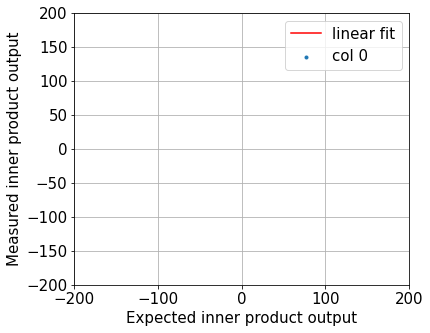

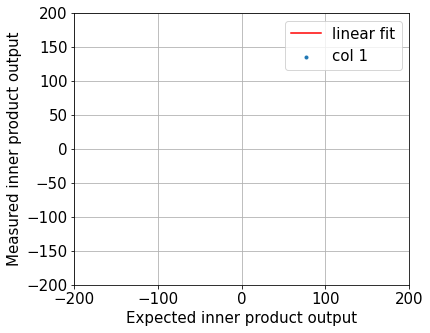

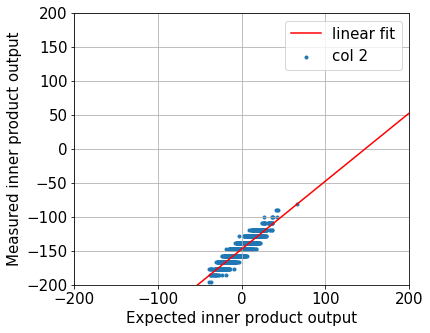

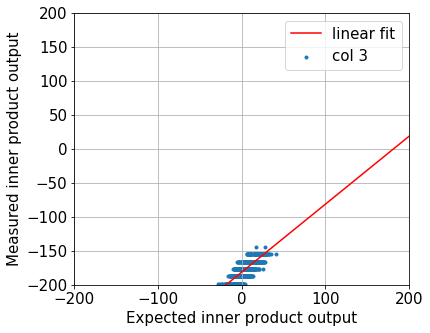

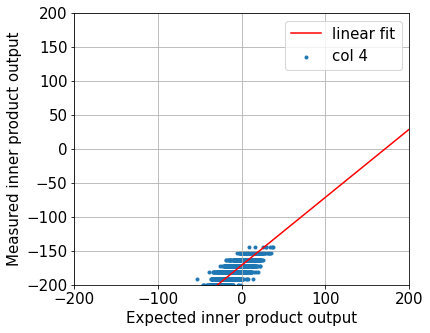

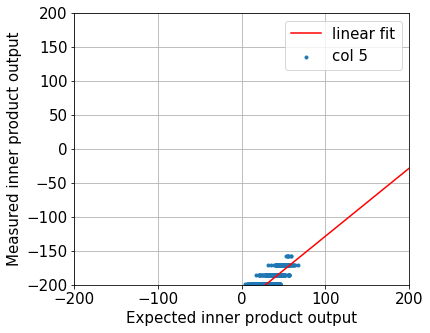

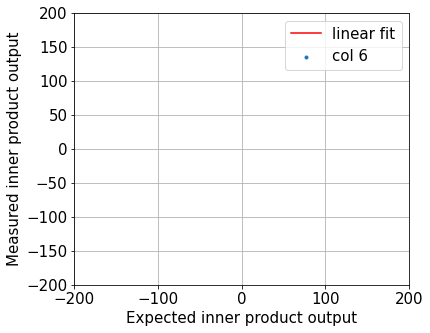

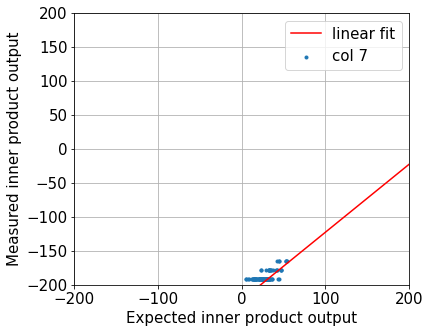

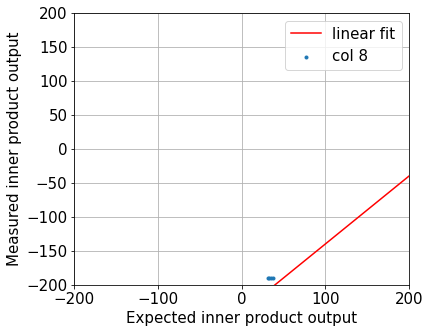

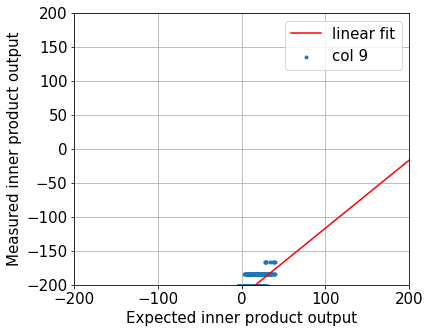

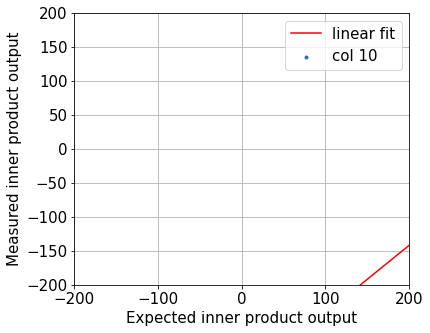

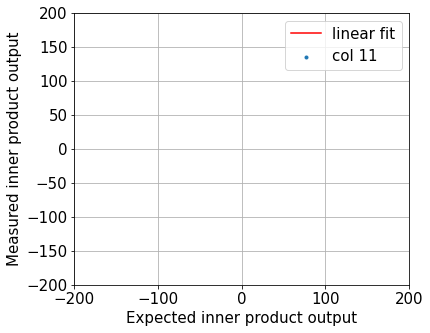

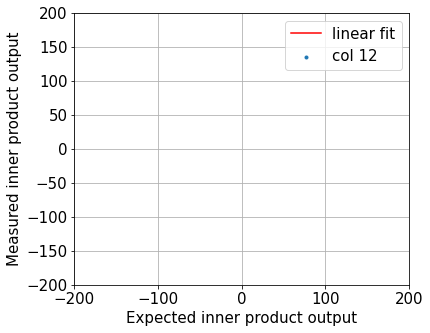

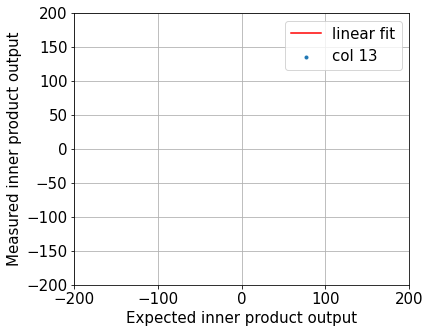

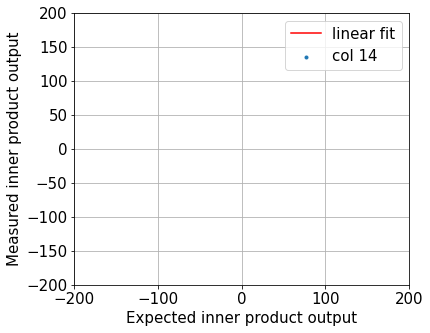

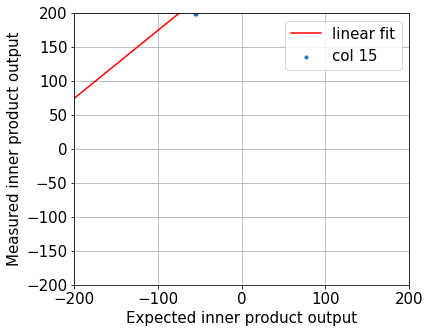

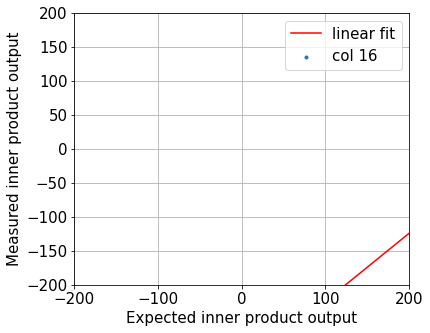

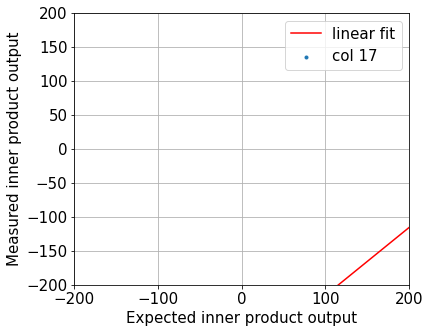

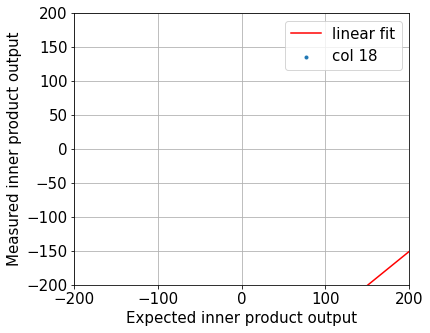

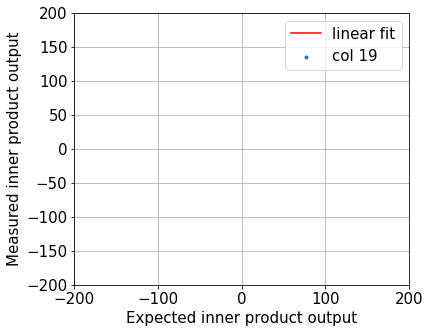

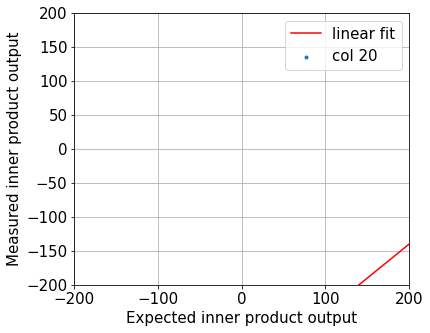

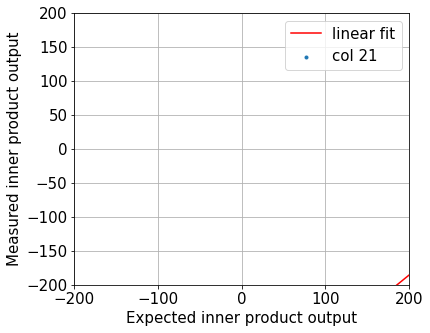

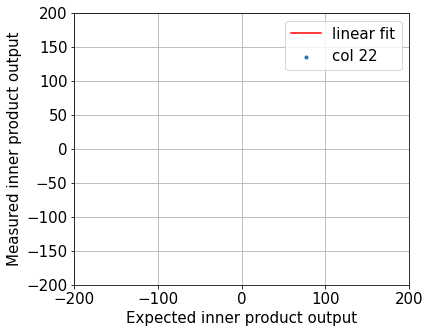

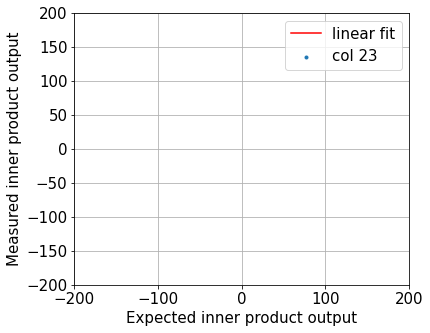

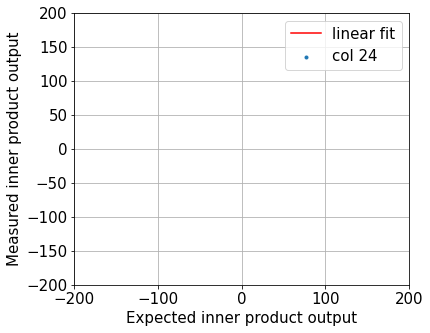

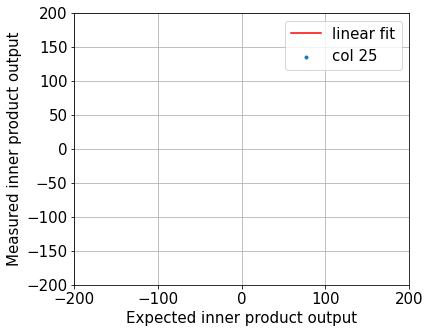

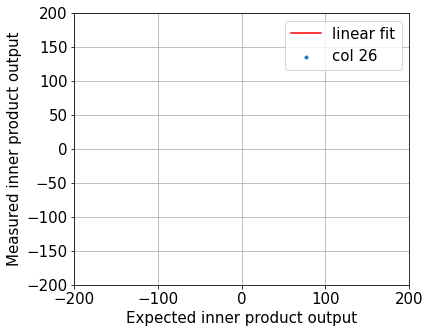

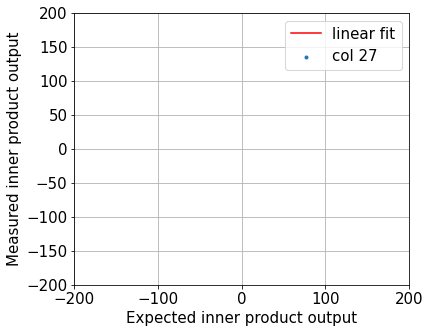

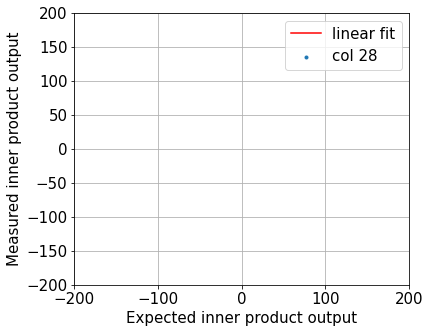

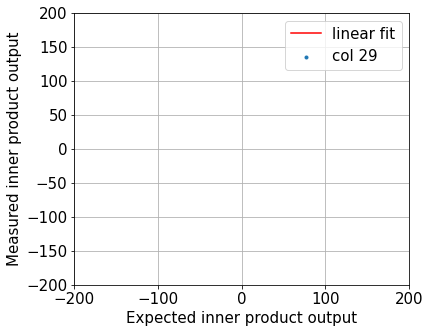

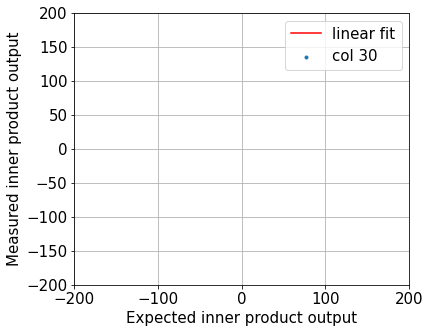

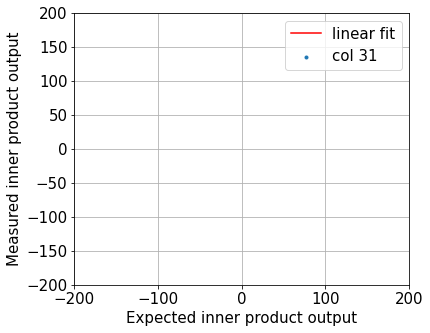

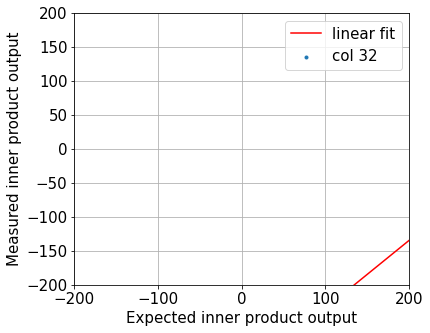

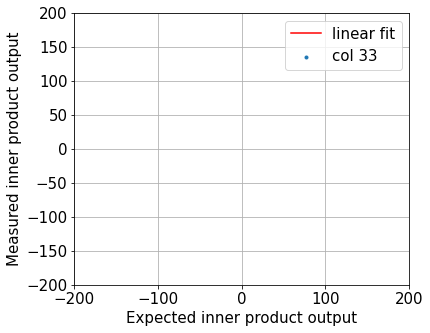

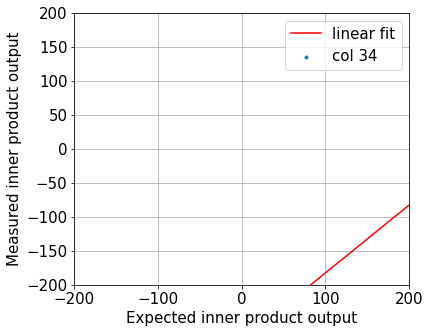

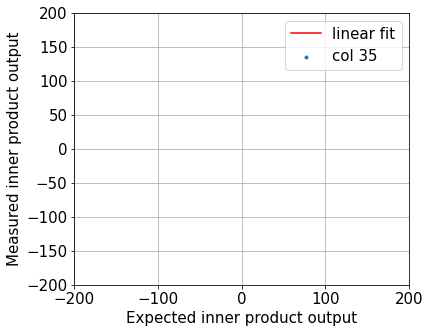

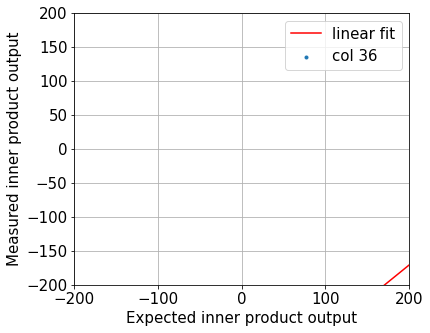

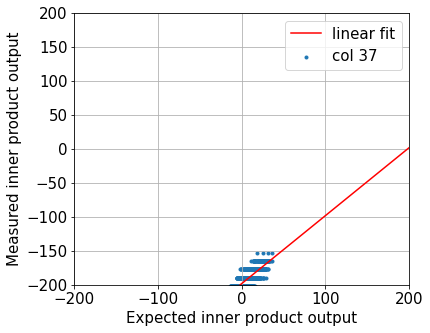

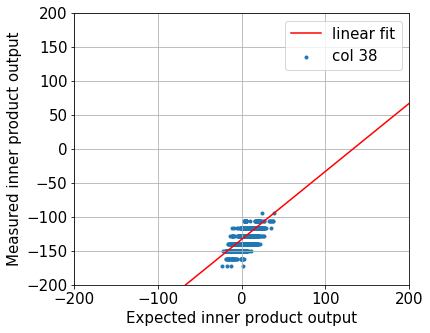

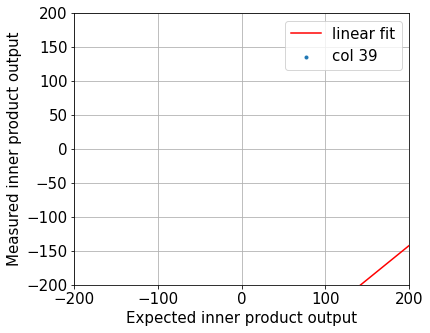

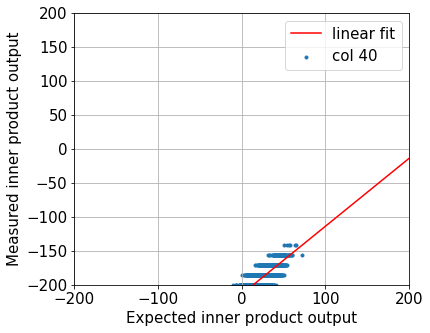

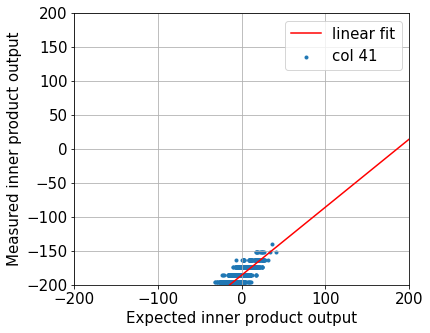

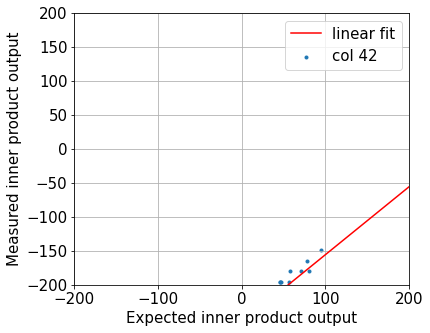

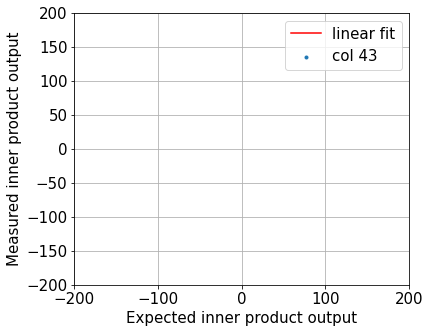

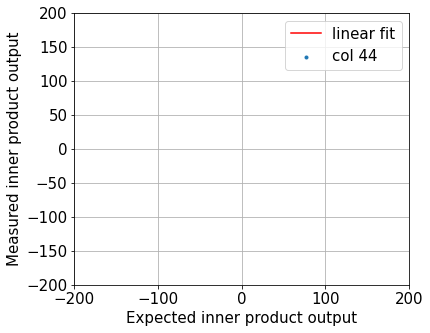

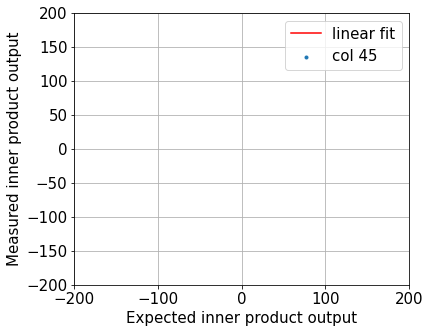

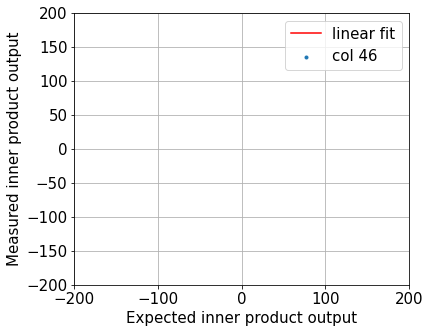

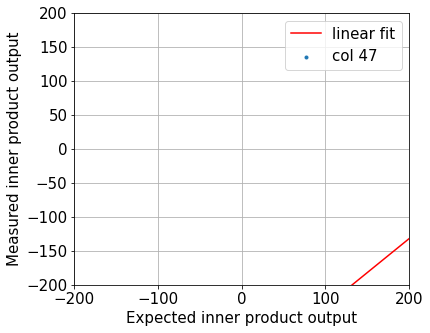

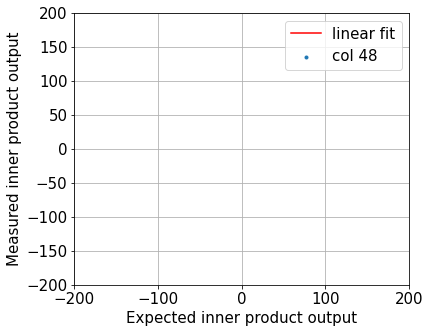

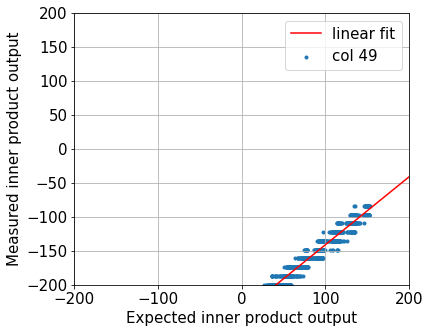

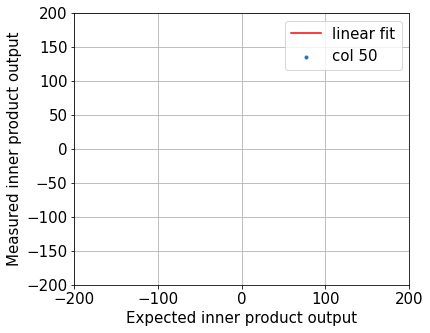

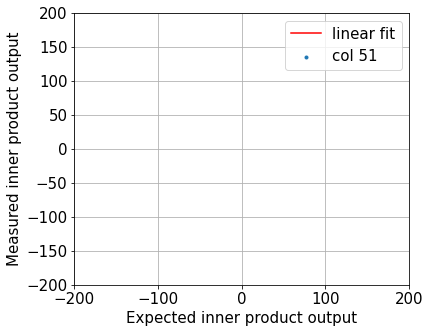

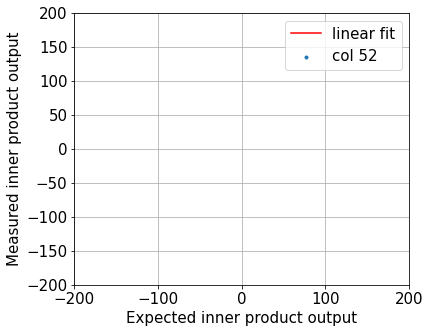

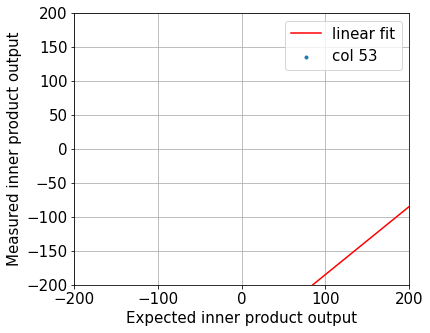

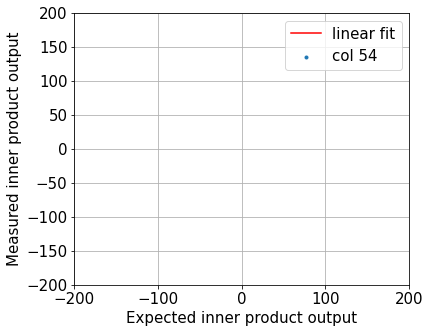

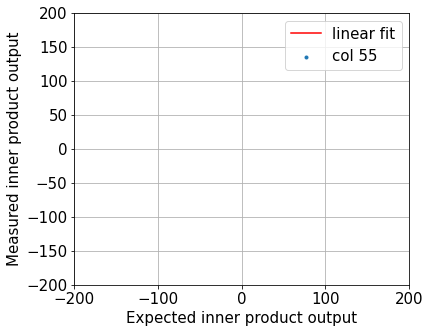

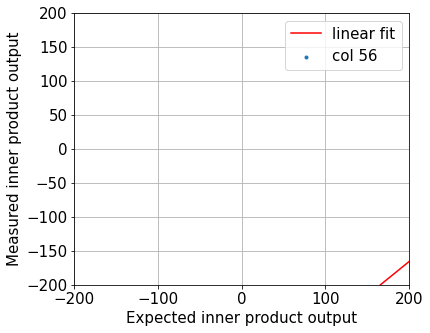

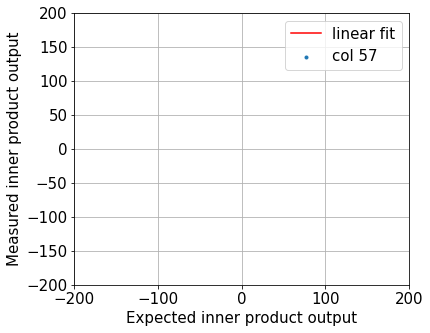

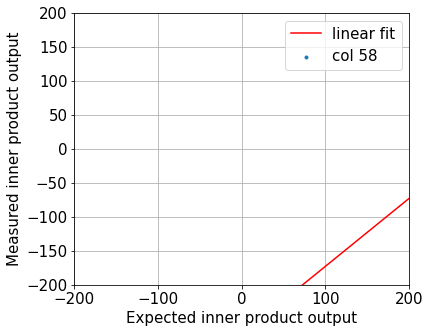

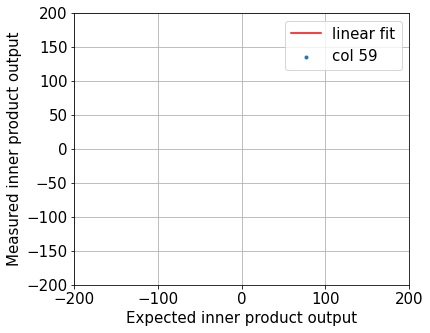

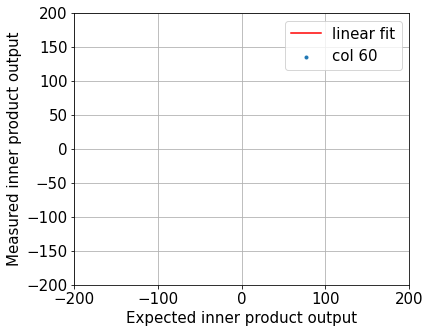

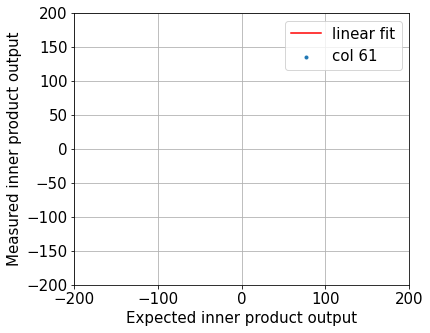

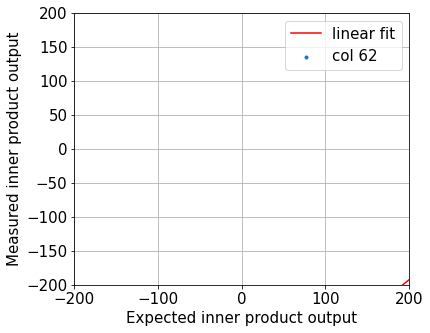

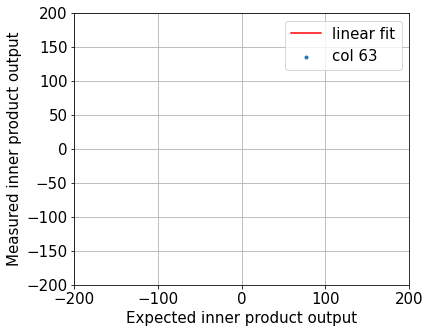

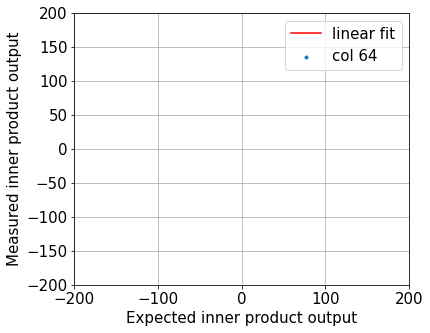

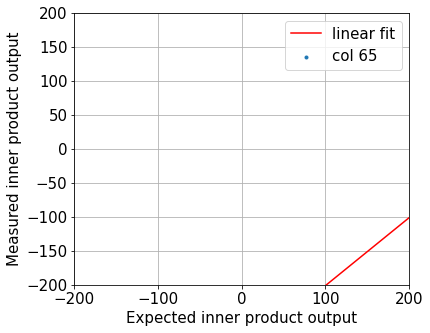

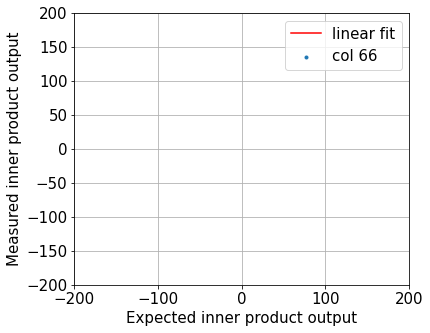

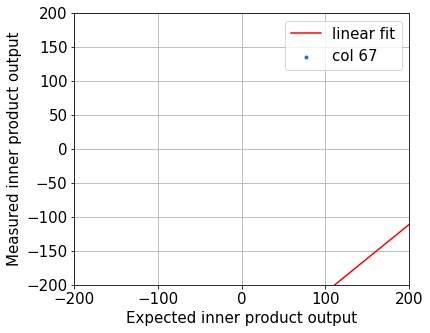

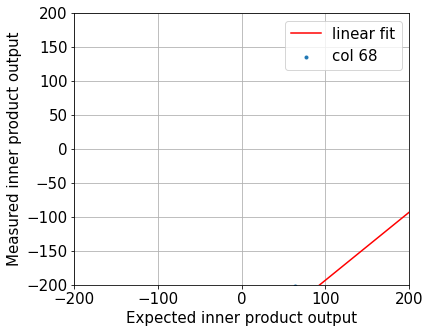

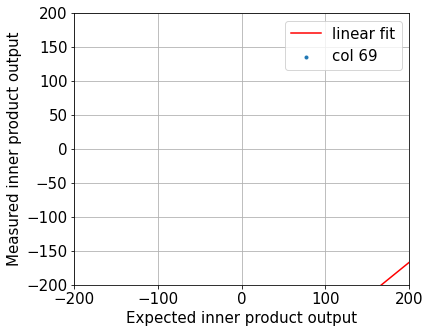

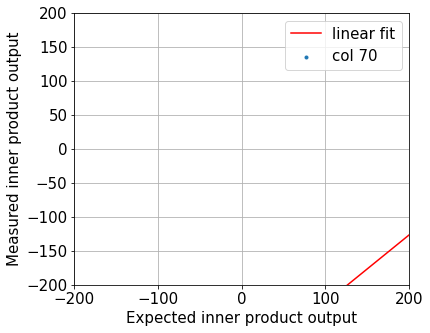

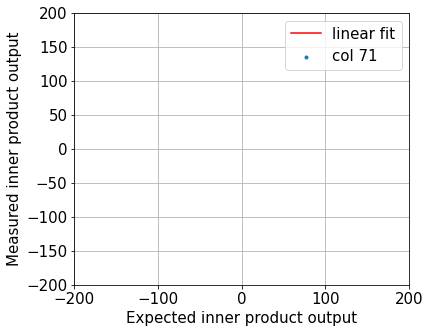

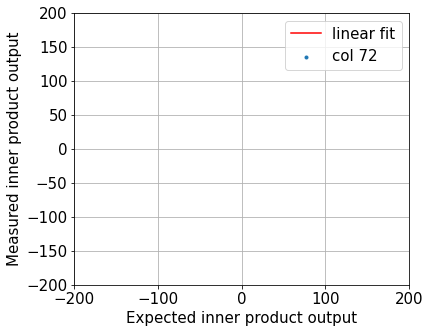

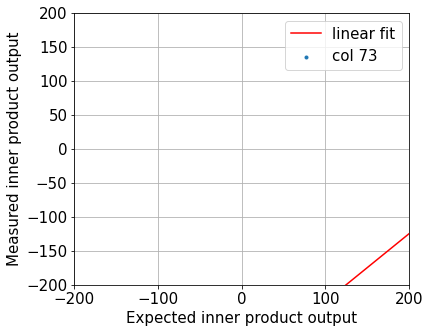

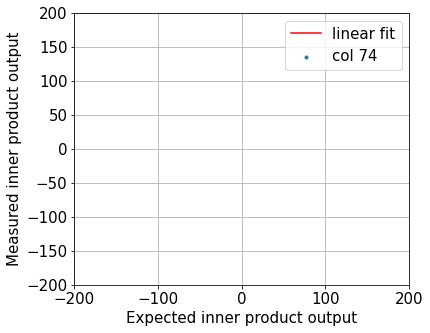

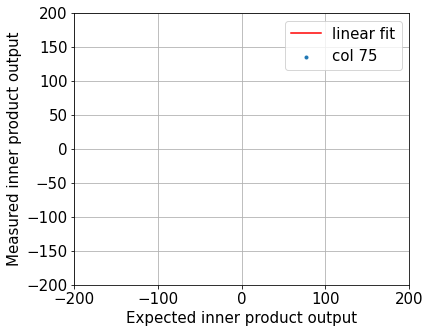

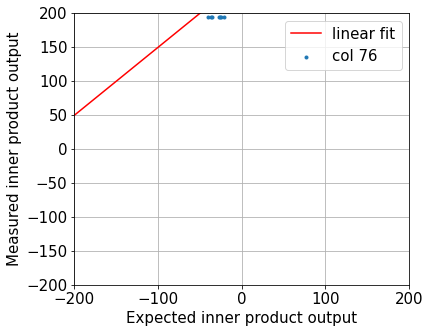

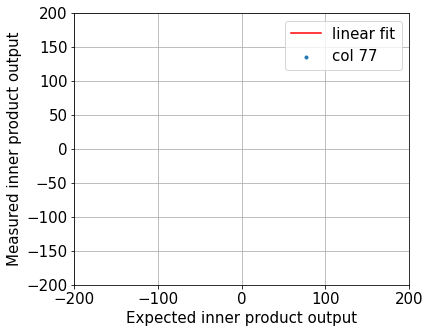

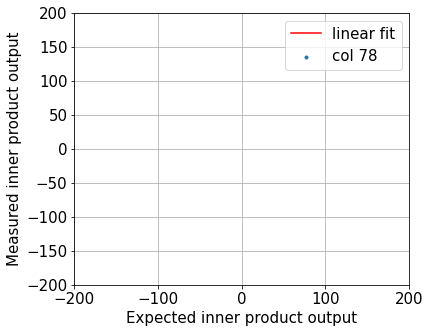

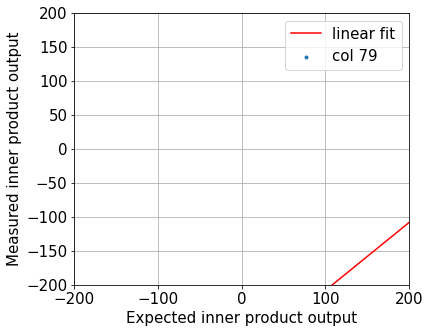

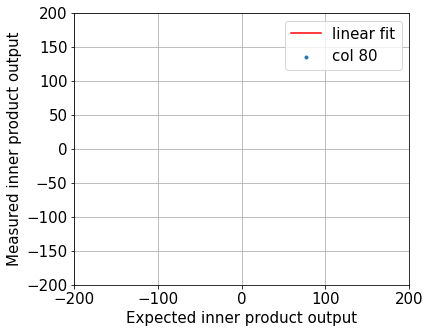

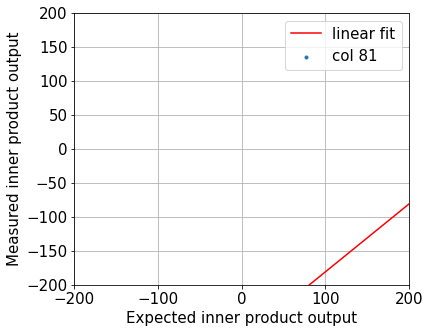

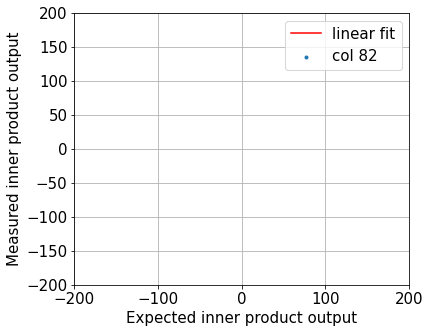

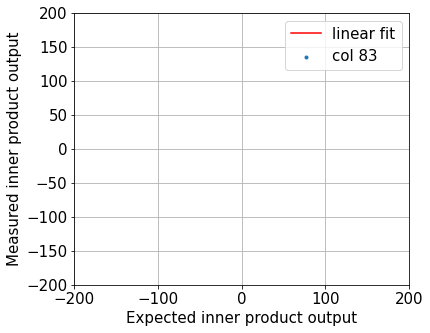

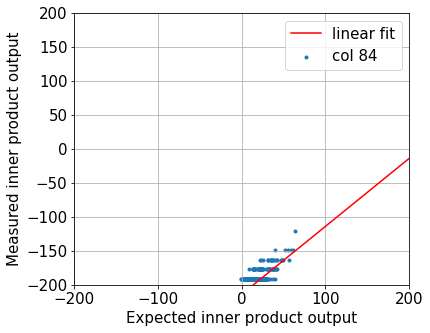

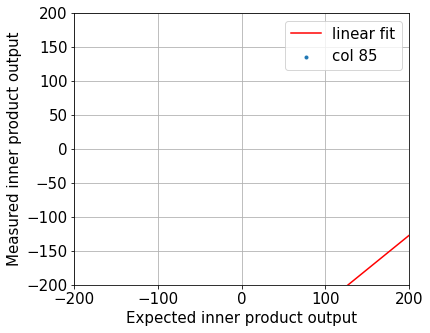

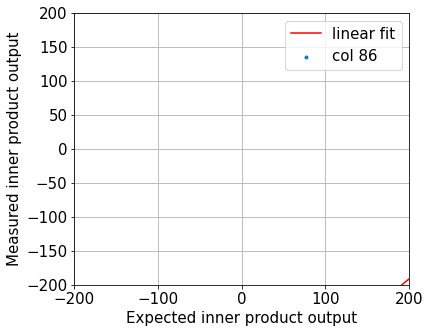

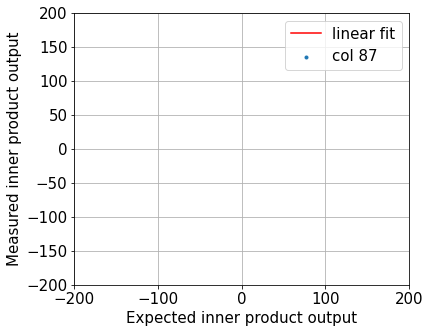

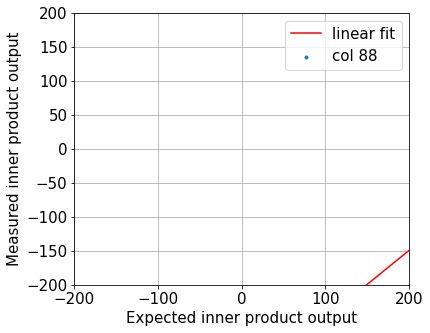

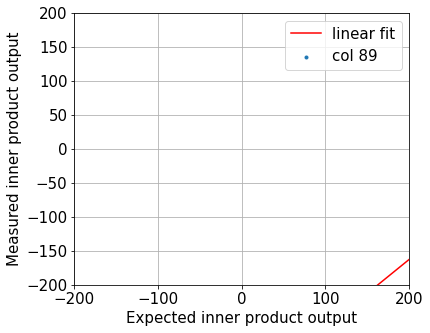

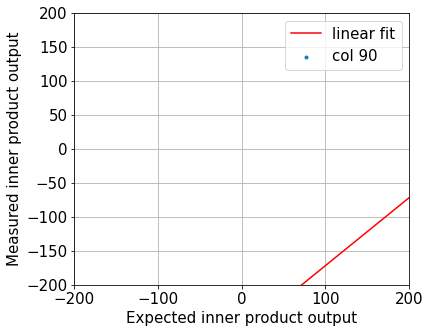

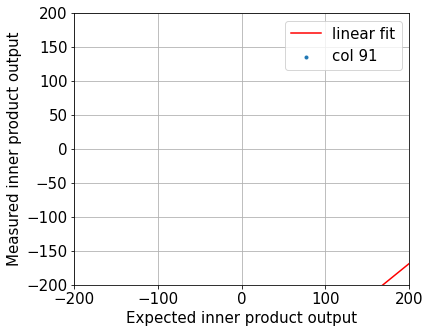

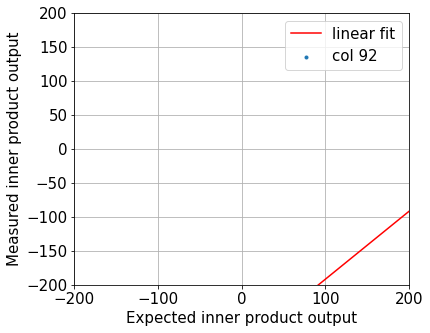

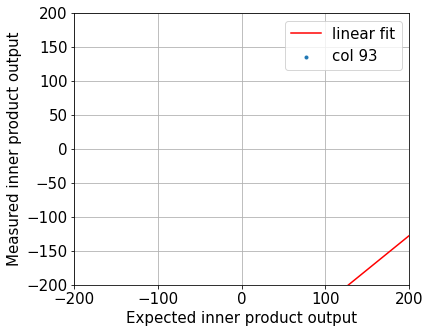

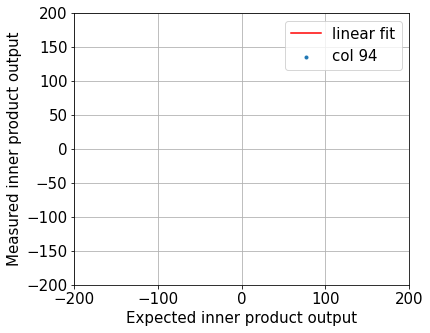

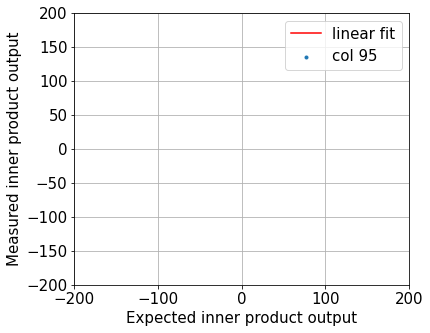

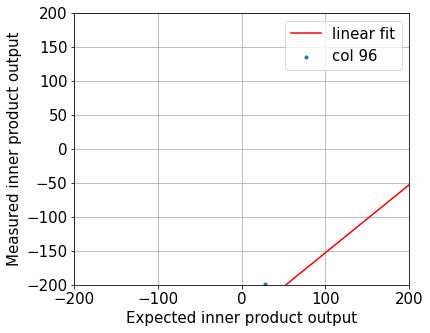

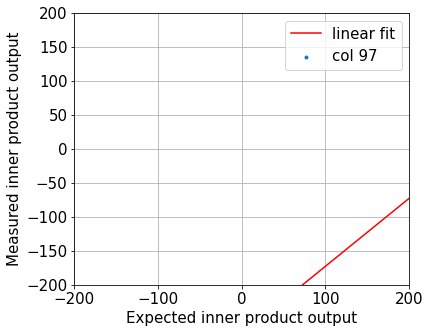

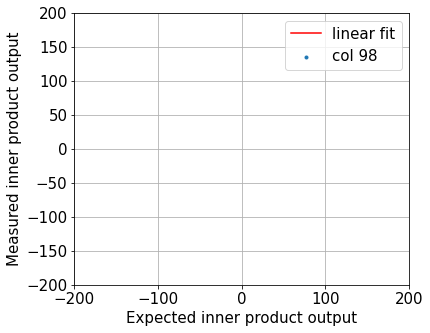

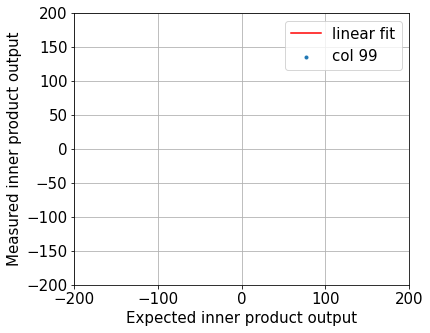

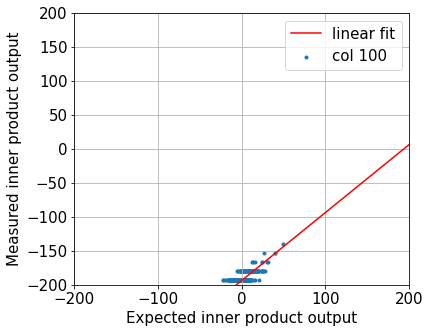

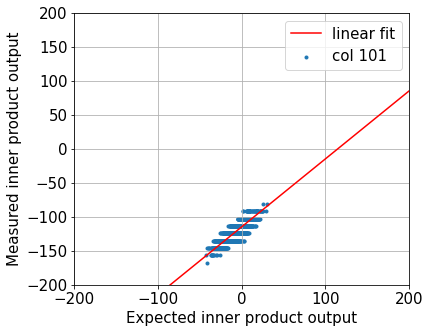

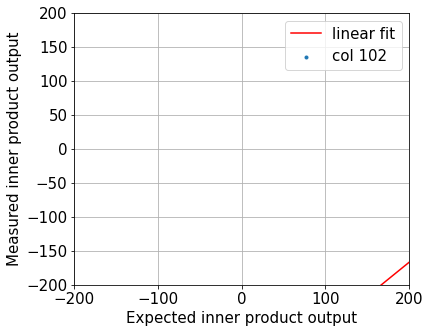

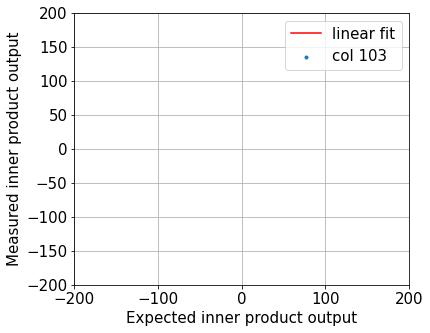

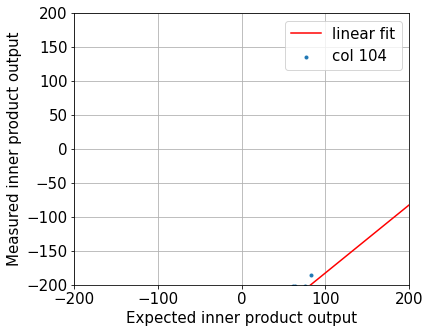

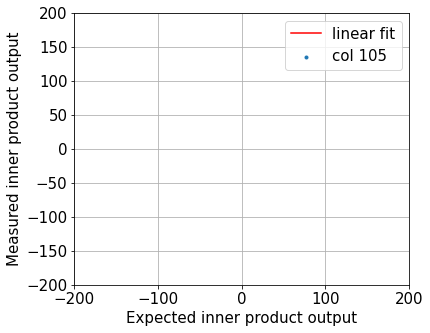

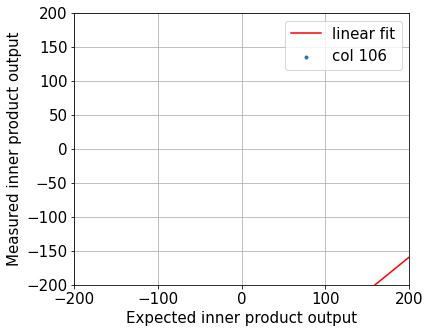

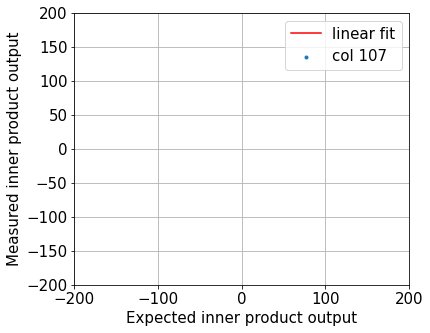

In [1307]:
exp_i = 6
act_i = 2
for c in range(108):

    p, res, _, _, _ = np.polyfit(expected_outputs[exp_i, :, c].flatten(), actual_outputs[act_i, :, c].flatten(), 1, full=True)
    y_fit = np.poly1d(p)
    std = np.sqrt(res)
    x = np.arange(-400, 400, 0.1)

    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(6,5))
    plt.scatter(expected_outputs[exp_i, :, c], actual_outputs[act_i, :, c]/p[0], label='col %d' % c, marker='.')
    plt.plot(x, y_fit(x)/p[0], 'r', label='linear fit')
    plt.grid()
    plt.xlim(-200, 200)
    plt.ylim(-200, 200)
    plt.xlabel('Expected inner product output')
    plt.ylabel('Measured inner product output')
    plt.legend()


#     print(p[0])
    print((c, std[0]/p[0]))

# Evaluate Inference Accuracy

In [13]:
num_time_step, ITERATION, _ = inputs.shape
ITERATION = 5092
acc_aux = []
for s in range(int(np.ceil(ITERATION / batch_size))):
    output = model(torch.from_numpy(inputs[:, s*batch_size : (s+1)*batch_size, :]))
    acc_aux.append(output.data.numpy().argmax(axis=1) == labels[s*batch_size : (s+1)*batch_size])

test_acc = np.hstack(acc_aux).mean()
print("Test Accuracy: {0:.4f}".format(test_acc))

Test Accuracy: 0.8749


In [ ]:
num_time_step, ITERATION, _ = inputs.shape
ITERATION = 256
acc_aux = []


# weight_ih_clip_torch = torch.from_numpy(weight_ih_clip)
# bias_ih_clip_torch = torch.from_numpy(bias_ih_clip)
# weight_hh_clip_torch = torch.from_numpy(weight_hh_clip)
# bias_hh_clip_torch = torch.from_numpy(bias_hh_clip)

pact_a_bmm = model_lib.pact_a_bmm
quant_pass = model_lib.quant_pass
bmm = model_lib.CustomMM_bmm.apply

for s in range(int(np.ceil(ITERATION / batch_size))):
    cx = torch.zeros(n_msb, batch_size, hidden, device=device)
    hx = torch.zeros(n_msb, batch_size, hidden, device=device)
    for time_step in range(num_time_step):
#         part1 = quant_pass(pact_a_bmm(torch.from_numpy(inputs[time_step, s*batch_size : (s+1)*batch_size, :]).repeat(4,1,1), a1), quant_inp, a1).bmm(weight_ih_clip_torch) + bias_ih_clip_torch
#         part2 = quant_pass(pact_a_bmm(hx, a11), quant_inp, a11).bmm(weight_hh_clip_torch) + bias_hh_clip_torch
        part1 = bmm(quant_pass(pact_a_bmm(torch.from_numpy(inputs[time_step, s*batch_size : (s+1)*batch_size, :]).repeat(4,1,1), a1), quant_inp, a1), weight_ih, bias_ih, 0.0, quant_w, rows_bias)
        part2 = bmm(quant_pass(pact_a_bmm(hx, a11), quant_inp, a11), weight_hh, bias_hh, 0.0, quant_w, rows_bias)
    
        gates = pact_a_bmm(pact_a_bmm(part1, a12) + pact_a_bmm(part2, a13), a14)

        i, j, f, o = gates.chunk(4, 2)

        forget_gate_out = pact_a_bmm(torch.sigmoid(f), a3)
        input_gate_out = pact_a_bmm(torch.sigmoid(i), a4)
        activation_out = pact_a_bmm(torch.tanh(j), a5)
        output_gate_out = pact_a_bmm(torch.sigmoid(o), a6)

        gated_cell = pact_a_bmm(cx * forget_gate_out, a7)
        activated_input = pact_a_bmm(input_gate_out * activation_out, a8)
        cx = pact_a_bmm(gated_cell + activated_input, a9)
        activated_cell = pact_a_bmm(torch.tanh(cx), a10)
        hx = pact_a_bmm(activated_cell * output_gate_out, a11)

    output = pact_a_bmm(model.finFC(hx).sum(0), a2)
    acc_aux.append(output.data.numpy().argmax(axis=1) == labels[s*batch_size : (s+1)*batch_size])

test_acc = np.hstack(acc_aux).mean()
print("Test Accuracy: {0:.4f}".format(test_acc))

In [750]:
hidden_scale = np.zeros([n_msb, ITERATION, hidden], dtype=np.float32)
cx = torch.from_numpy(np.zeros([n_msb, ITERATION, hidden], dtype=np.float32))

In [751]:
part1 = torch.from_numpy(inputs_scale).repeat(n_msb, 1, 1).bmm(torch.from_numpy(weight_ih_clip))
part2 = torch.from_numpy(hidden_scale).bmm(torch.from_numpy(weight_hh_clip))
    
# Replace partial results with chip output

gates = part1 + part2
i, j, f, o = gates.chunk(4, 2)
forget_gate_out = torch.sigmoid(f)
input_gate_out = torch.sigmoid(i)
activation_out = torch.tanh(j)
output_gate_out = torch.sigmoid(o)

gated_cell = cx * forget_gate_out
activated_input = input_gate_out * activation_out
new_c = gated_cell + activated_input
activated_cell = torch.tanh(new_c)
new_h = activated_cell * output_gate_out

acc_aux = []
for s in range(int(np.ceil(ITERATION / batch_size))):
    lstm_out, _ = model.lstmBlocks(torch.from_numpy(inputs[time_step+1:, s*batch_size : (s+1)*batch_size, :]),
                                   (new_h[:, s*batch_size : (s+1)*batch_size, :], new_c[:, s*batch_size : (s+1)*batch_size, :]))
    output = model.finFC(lstm_out[-1, :, :, :]).sum(0)
    acc_aux.append((output.data.numpy().argmax(axis=1) == labels[s*batch_size : (s+1)*batch_size]))

In [752]:
test_acc = np.hstack(acc_aux).mean()
print("Test Accuracy: {0:.4f}".format(test_acc))

Test Accuracy: 0.8814


In [17]:
output = model.finFC(torch.from_numpy(hx.astype(np.float32))).sum(0)
test_acc = np.mean(output.data.numpy().argmax(axis=1) == labels[:ITERATION])
print('Accuracy: {0:.4f}'.format(test_acc))

Accuracy: 0.8672


In [44]:
# num_time_step, ITERATION, _ = inputs.shape
# ITERATION = 256
# cx = np.zeros([n_msb, ITERATION, hidden], dtype=np.float32)
# hx = np.zeros([n_msb, ITERATION, hidden], dtype=np.float32)

for time_step in range(15, 25):
    part1 = np.zeros([n_msb, ITERATION, hidden*num_gate], dtype=np.float32)
    part2 = np.zeros([n_msb, ITERATION, hidden*num_gate], dtype=np.float32)
    for block in range(n_msb):
        input_quantized = quantize_signed(inputs[time_step, :ITERATION, :], quant_inp, a1[block])
        input_scale = quantize_signed_rescale(input_quantized, quant_inp, a1[block])
        part1[block] = input_scale.dot(weight_ih_clip[block]) + bias_ih_clip[block]
        hidden_quantized = quantize_signed(hx[block], quant_inp, a11[block])
        hidden_scale = quantize_signed_rescale(hidden_quantized, quant_inp, a11[block])
        part2[block] = hidden_scale.dot(weight_hh_clip[block]) + bias_hh_clip[block]
#         if block == 3:
#         part1[block] = hidden_state_ih_shift[time_step, block, :, :]
        
    
    gates = fake_quant_signed(fake_quant_signed(part1, quant_actMVM, a12) + fake_quant_signed(part2, quant_actMVM, a13), quant_actNM, a14)
    i, j, f, o = np.split(gates, 4, axis=2)
    forget_gate_out = fake_quant_signed(sigmoid(f), quant_actNM, a3)
    input_gate_out = fake_quant_signed(sigmoid(i), quant_actNM, a4)
    activation_out = fake_quant_signed(np.tanh(j), quant_actNM, a5)
    output_gate_out = fake_quant_signed(sigmoid(o), quant_actNM, a6)
    
    gated_cell = fake_quant_signed(cx * forget_gate_out, quant_actNM, a7)
    activated_input = fake_quant_signed(input_gate_out * activation_out, quant_actNM, a8)
    cx = fake_quant_signed(gated_cell + activated_input, quant_actNM, a9)
    activated_cell = fake_quant_signed(np.tanh(cx), quant_actNM, a10)
    hx = fake_quant_signed(activated_cell * output_gate_out, quant_actNM, a11)
    print('Finished time step %d' % time_step)

Finished time step 15
Finished time step 16
Finished time step 17
Finished time step 18
Finished time step 19
Finished time step 20
Finished time step 21
Finished time step 22
Finished time step 23
Finished time step 24


In [46]:
weight_scale = np.abs(weight).max()
print(weight_scale)
quant_scale = 2**(4-1) / relux[0][0]
print(quant_scale)

0.2
7.996781690718191


In [47]:
scaled_output = part2[block, :, hidden*gate:hidden*(gate+1)] / weight_scale * quant_scale

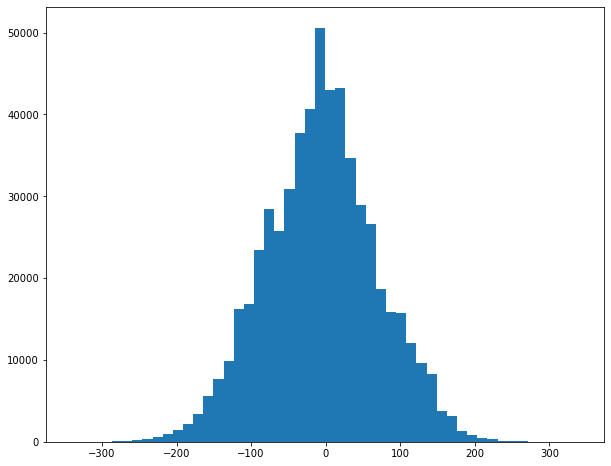

In [48]:
plt.hist(scaled_output.flatten(), 50);

In [49]:
np.save(DATA_PATH + 'scaled_hidden_hh_dist_step_25', scaled_output)

In [42]:
np.save(DATA_PATH + 'weight_normalization_factor_hh_block0_gate0', np.sum(np.abs(weight/0.2), axis=0))

In [1421]:
hidden_state_ih_shift = np.load(DATA_PATH + 'hidden_state_ih_shift.npy')

In [339]:
output = np.load(DATA_PATH + 'fc_output_2.npz')['output']

In [331]:
output = np.zeros([n_msb, ITERATION, len(word_list)], dtype=np.float32)
for block in range(n_msb):
    output[block] = hx[block].dot(weight_fc_clip[block]) + bias_fc_clip[block]

In [343]:
DATA_SIZE = 5090
results = fake_quant_signed(output[0], quant_actNM, fc_a2[0]).argmax(axis=1)
test_acc = np.mean(results[:DATA_SIZE] == labels[:DATA_SIZE])
print('Accuracy: {0:.4f}'.format(test_acc))

for cl, word in enumerate(word_list):
    mask = labels[:DATA_SIZE] == cl
    print('Accuracy for %s: %f' % (word, np.mean(results[:DATA_SIZE][mask] == labels[:DATA_SIZE][mask])))

Accuracy: 0.4165
Accuracy for yes: 0.062201
Accuracy for no: 0.740741
Accuracy for up: 0.011765
Accuracy for down: 0.315271
Accuracy for left: 0.274272
Accuracy for right: 0.225316
Accuracy for on: 0.684343
Accuracy for off: 0.208955
Accuracy for stop: 0.905109
Accuracy for go: 0.294264
Accuracy for unknown: 0.361493
Accuracy for silence: 0.843137


In [1099]:
num_time_step, ITERATION, _ = inputs.shape
errors_hidden_state_ih = np.zeros([num_time_step, n_msb, num_gate])

for time_step in range(num_time_step):
    for block in range(n_msb):
        for gate in range(num_gate):
            input_quantized = quantize_signed(inputs[time_step, :ITERATION, :], quant_inp, a1[block])
            input_scale = quantize_signed_rescale(input_quantized, quant_inp, a1[block])
            expected_outputs = input_scale.dot(weight_ih_clip[block, :, hidden*gate:hidden*(gate+1)]) + bias_ih_clip[block, 0, hidden*gate:hidden*(gate+1)]
            actual_outputs = hidden_state_ih_shift[time_step, block, :, hidden*gate:hidden*(gate+1)]
            errors_hidden_state_ih[time_step, block, gate] = np.linalg.norm(actual_outputs - expected_outputs)
       
    print('Finished time step %d' % time_step)

Finished time step 0
Finished time step 1
Finished time step 2
Finished time step 3
Finished time step 4
Finished time step 5
Finished time step 6
Finished time step 7
Finished time step 8
Finished time step 9
Finished time step 10
Finished time step 11
Finished time step 12
Finished time step 13
Finished time step 14
Finished time step 15
Finished time step 16
Finished time step 17
Finished time step 18
Finished time step 19
Finished time step 20
Finished time step 21
Finished time step 22
Finished time step 23
Finished time step 24
Finished time step 25
Finished time step 26
Finished time step 27
Finished time step 28
Finished time step 29
Finished time step 30
Finished time step 31
Finished time step 32
Finished time step 33
Finished time step 34
Finished time step 35
Finished time step 36
Finished time step 37
Finished time step 38
Finished time step 39
Finished time step 40
Finished time step 41
Finished time step 42
Finished time step 43
Finished time step 44
Finished time step 4

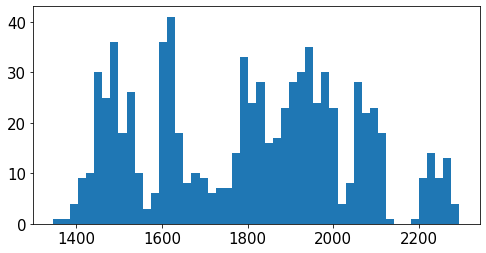

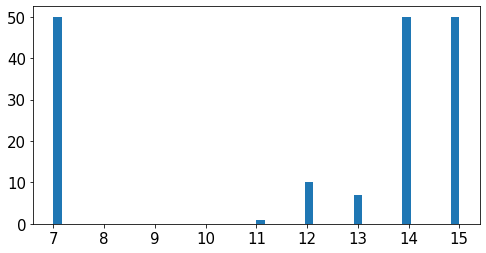

In [1105]:
plt.figure(figsize=(8,4))
plt.hist(errors_hidden_state_ih.flatten(), 50);
error_entries = np.argwhere(errors_hidden_state_ih > 2000)
error_entries = [i[1]*4+i[2] for i in error_entries]
plt.figure(figsize=(8,4))
plt.hist(error_entries, 50);

1834.3722


array([93,  7, 44], dtype=int64)

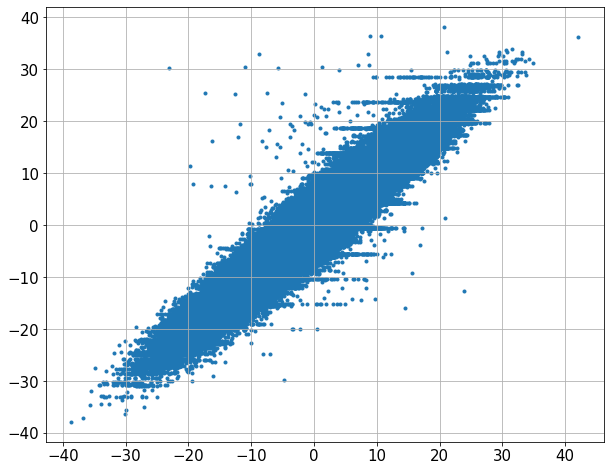

In [52]:
ITERATION = 5092
time_step = 25
block = 1
gate = 0
input_quantized = quantize_signed(inputs[time_step, :ITERATION, :], quant_inp, a1[block])
input_scale = quantize_signed_rescale(input_quantized, quant_inp, a1[block])
expected_outputs = input_scale.dot(weight_ih_clip[block, :, hidden*gate:hidden*(gate+1)]) + bias_ih_clip[block, 0, hidden*gate:hidden*(gate+1)]
actual_outputs = hidden_state_ih_shift[time_step, block, :, hidden*gate:hidden*(gate+1)]
plt.scatter(expected_outputs.flatten(), actual_outputs.flatten(), marker='.')
# plt.xlim(-6, 6)
# plt.ylim(-6, 6)
plt.grid()

print(np.linalg.norm(actual_outputs - expected_outputs))
errors_col = np.linalg.norm(actual_outputs - expected_outputs, axis=0)
np.argsort(errors_col)[-3:][::-1]

349.8631


array([48, 43, 66], dtype=int64)

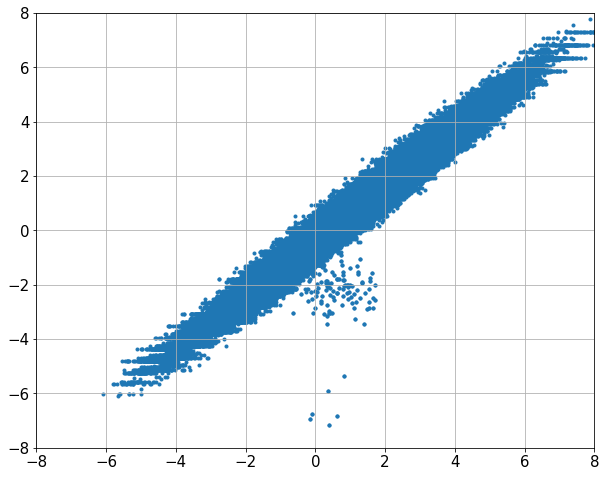

In [77]:
time_step = 49
block = 3
gate = 3

hx = hidden_state[time_step-1]
relux = a11[block, 0, 0]
hidden_quantized = nn_layers.quantize_signed(hx[block], num_bits, relux)
hidden_scale = nn_layers.quantize_signed_rescale(hidden_quantized, num_bits, relux)
expected_outputs = hidden_scale.dot(weight_hh_clip[block, :, hidden*gate:hidden*(gate+1)]) + bias_hh_clip[block, 0, hidden*gate:hidden*(gate+1)]
actual_outputs = hidden_state_hh[time_step, block, :, hidden*gate:hidden*(gate+1)]
plt.scatter(expected_outputs.flatten(), actual_outputs.flatten(), marker='.')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.grid()

print(np.linalg.norm(actual_outputs - expected_outputs))
errors_col = np.linalg.norm(actual_outputs - expected_outputs, axis=0)
np.argsort(errors_col)[-3:][::-1]

C:\Users\Weier Wan\.conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


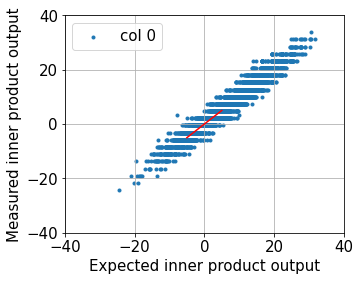

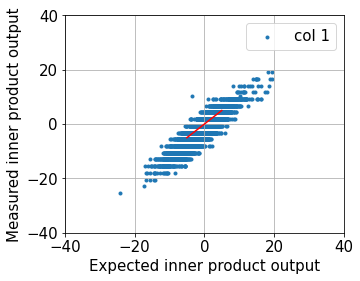

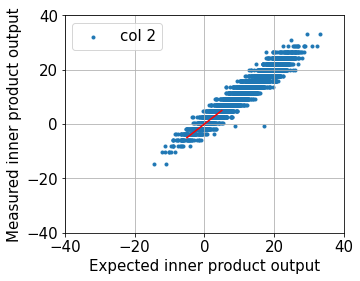

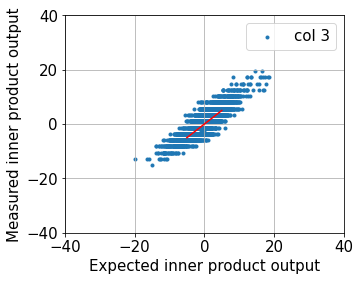

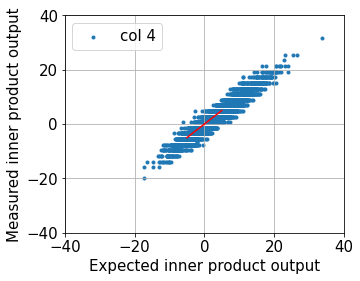

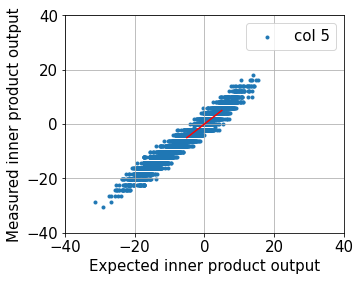

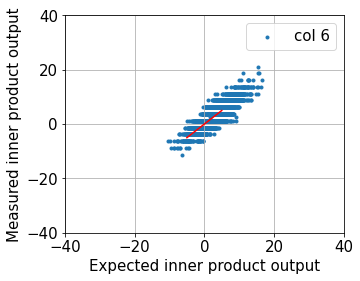

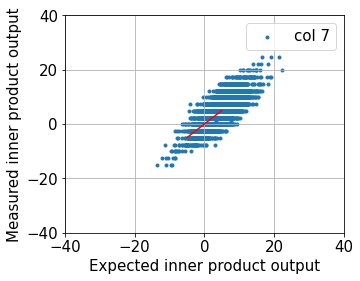

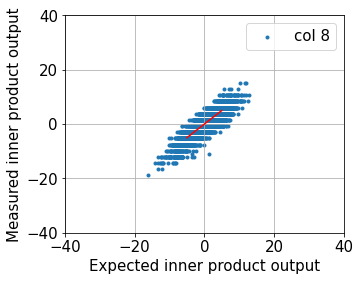

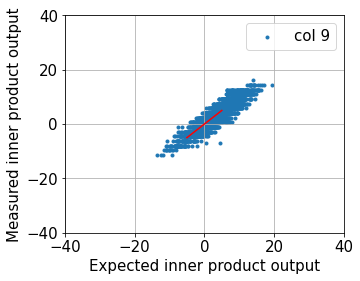

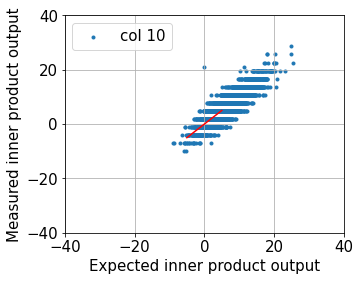

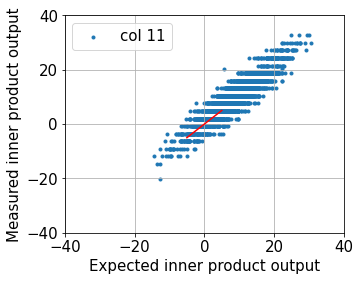

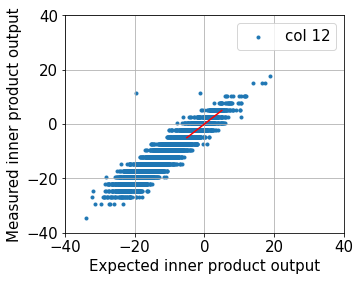

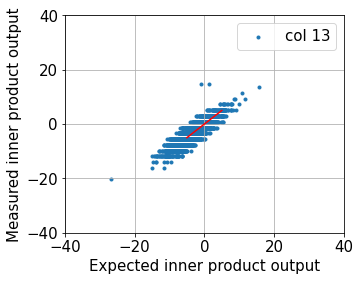

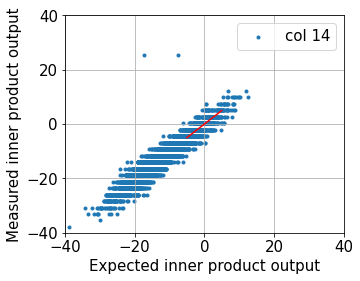

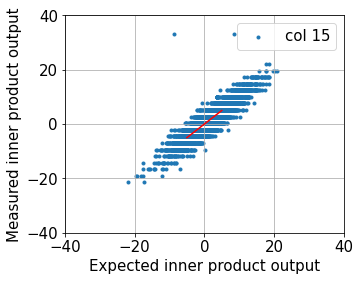

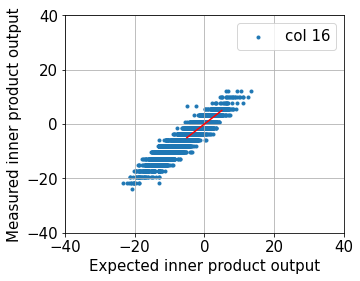

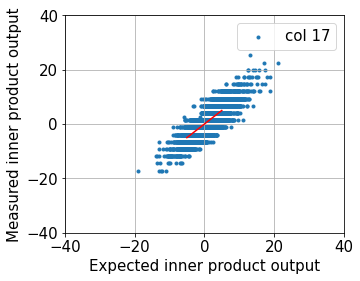

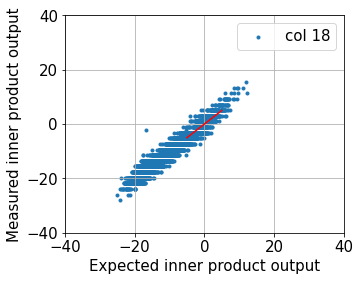

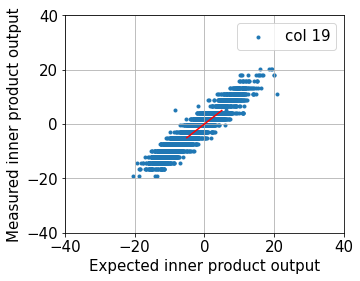

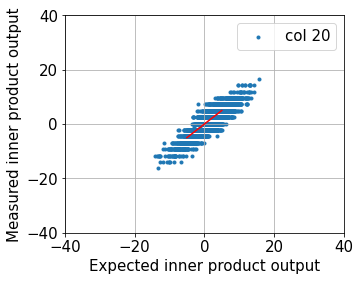

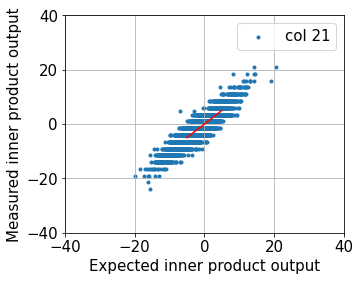

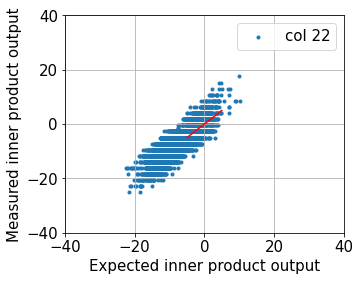

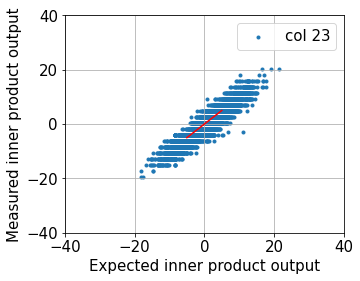

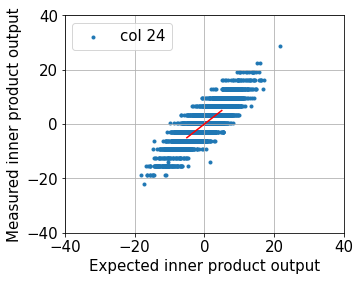

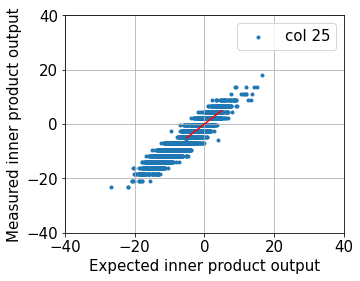

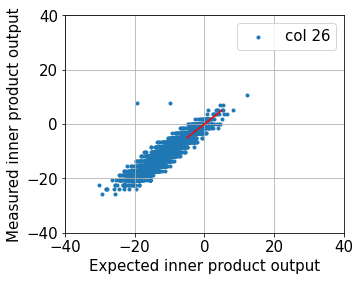

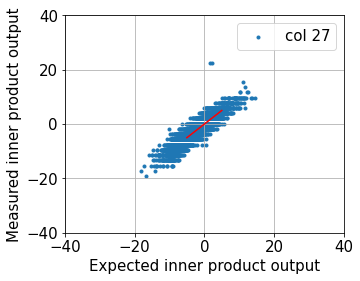

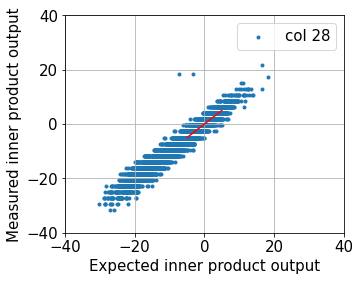

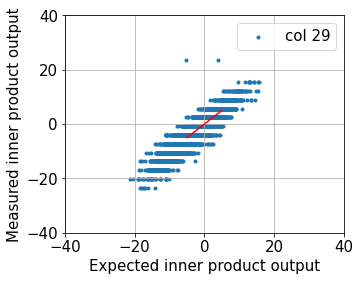

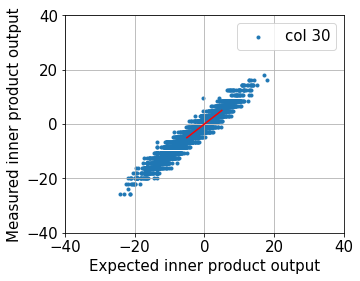

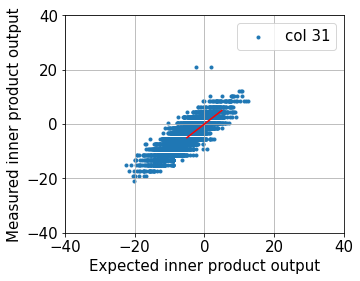

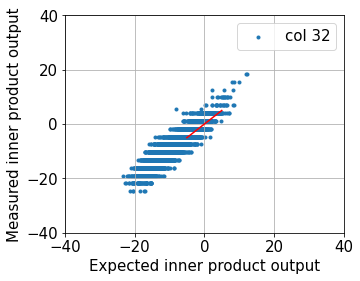

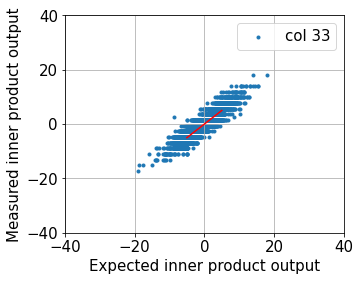

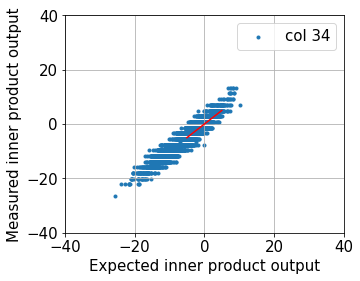

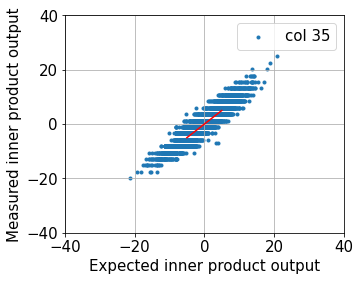

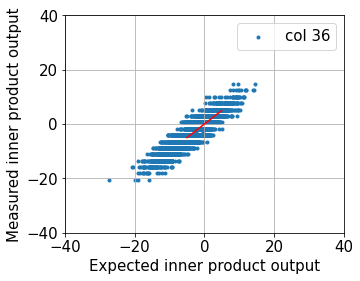

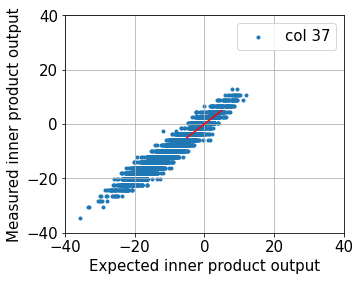

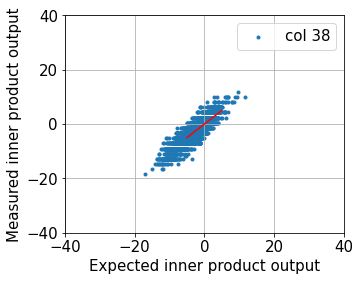

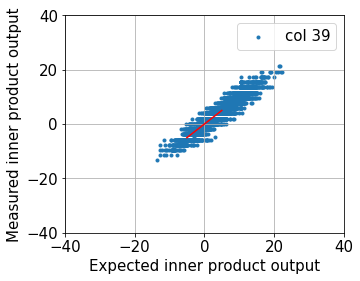

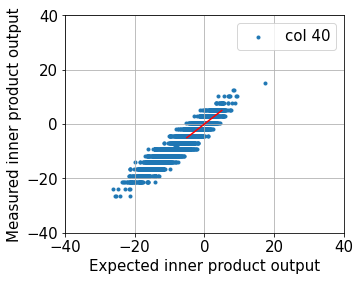

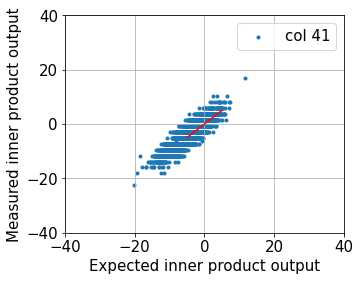

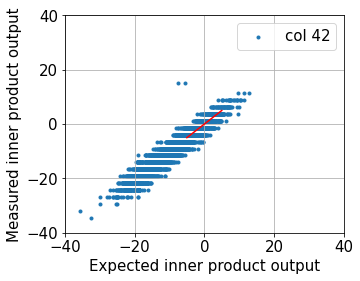

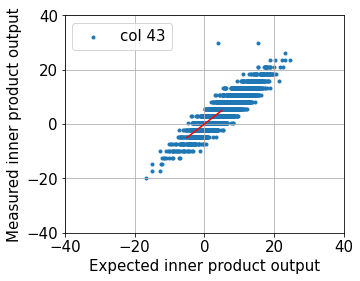

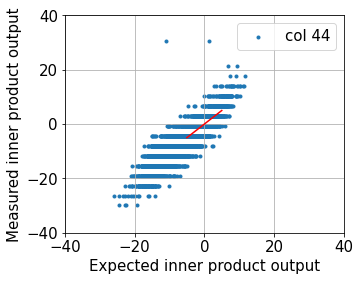

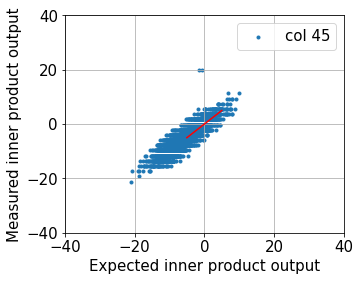

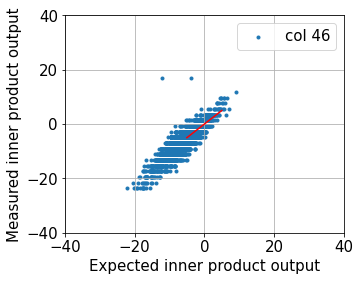

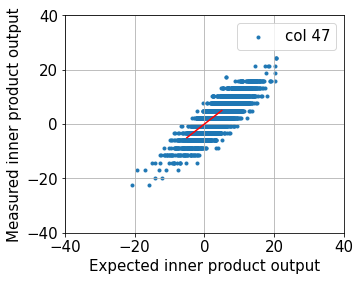

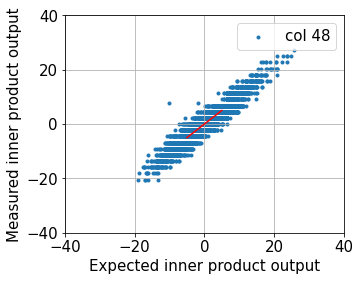

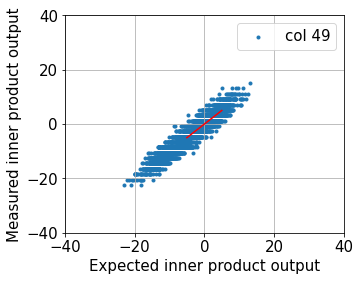

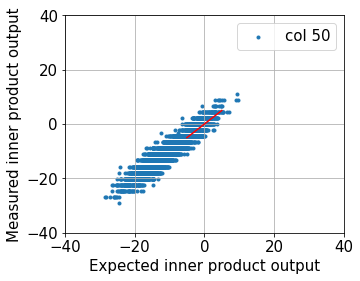

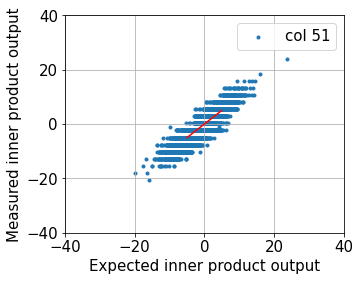

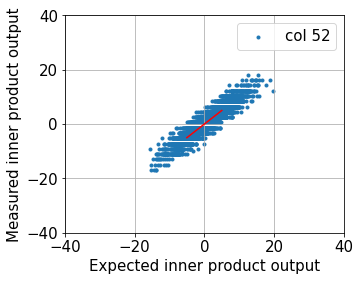

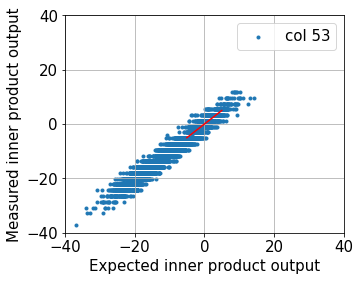

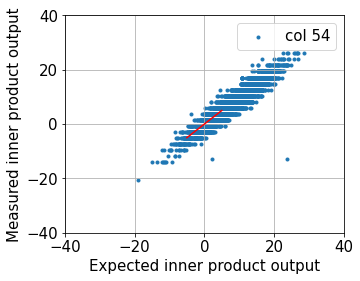

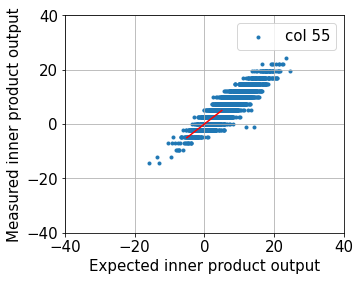

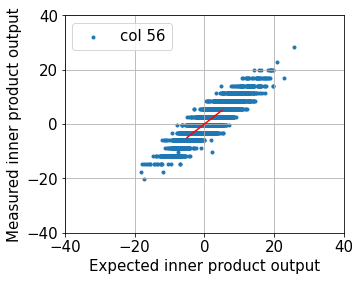

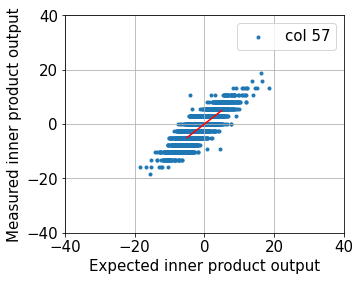

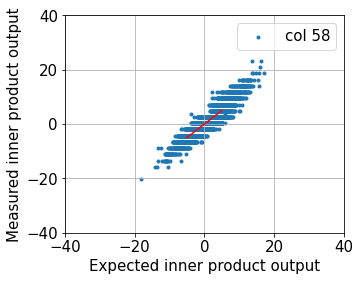

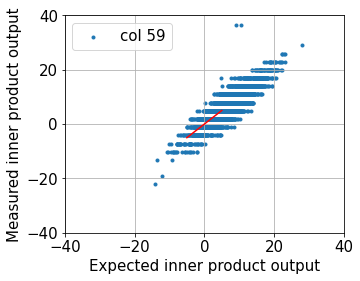

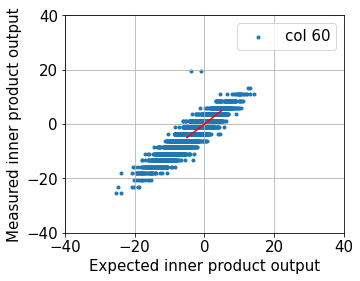

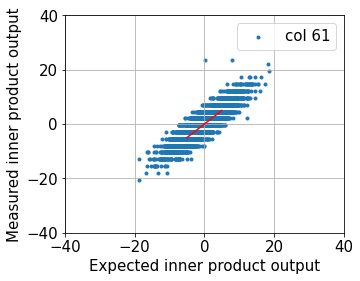

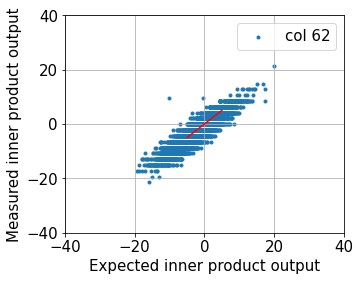

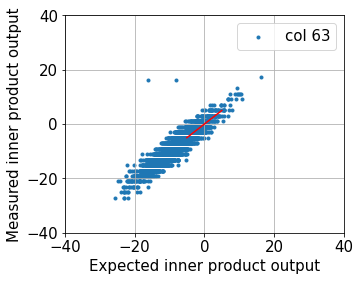

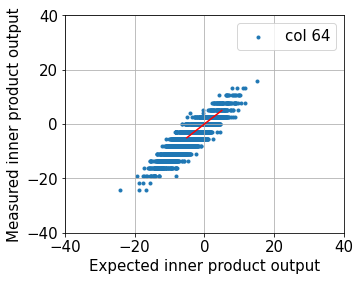

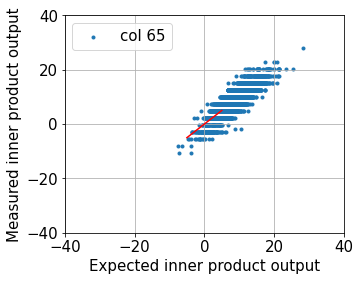

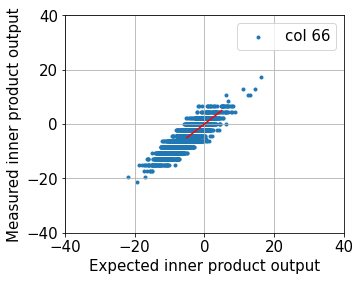

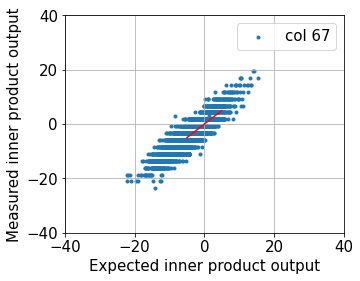

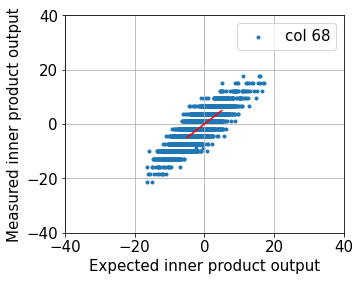

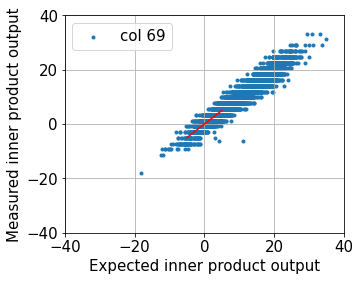

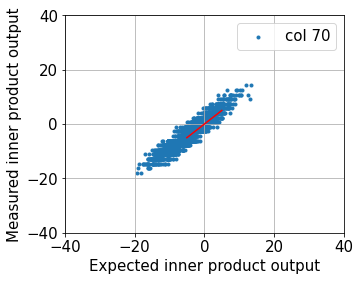

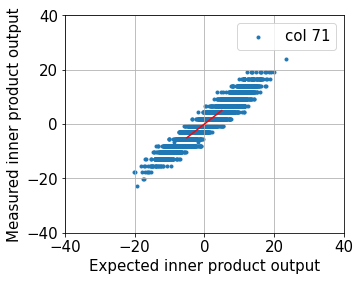

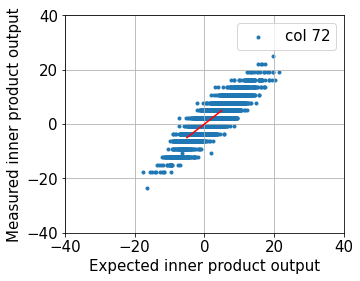

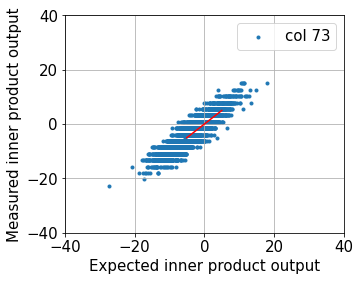

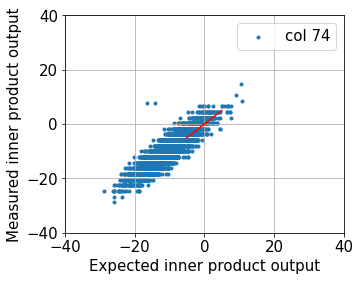

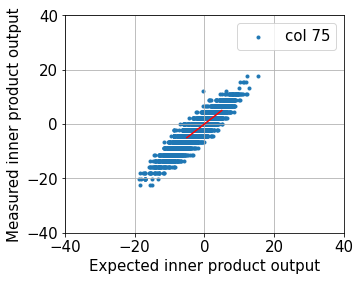

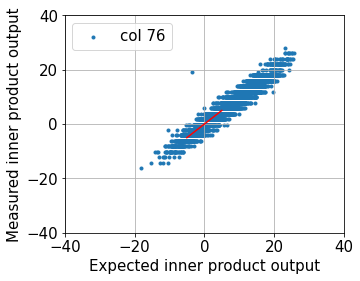

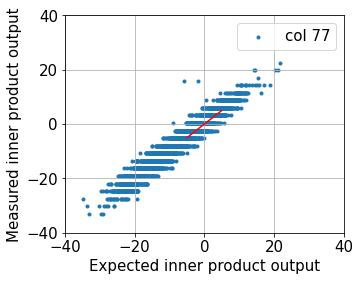

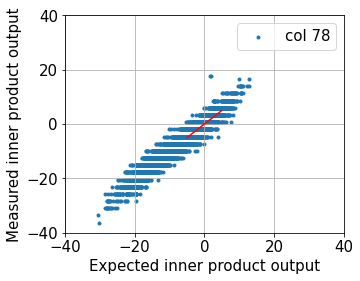

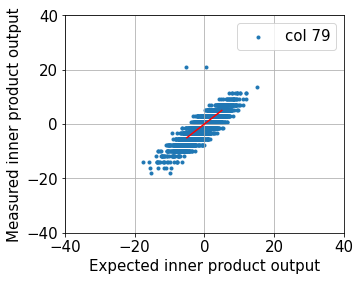

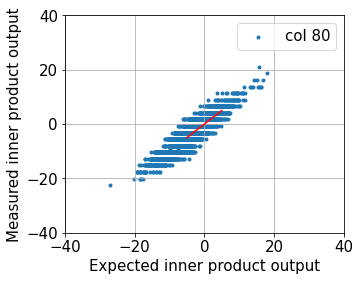

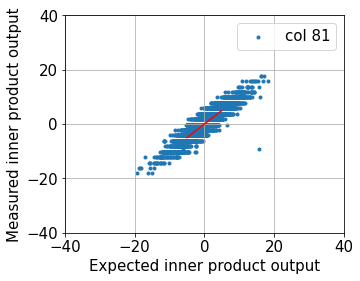

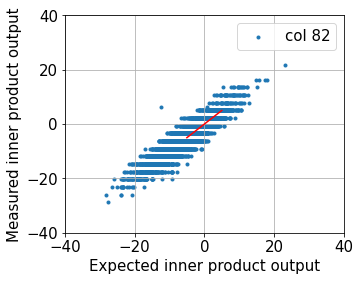

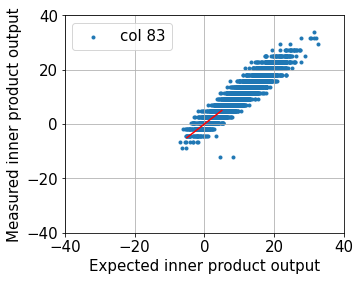

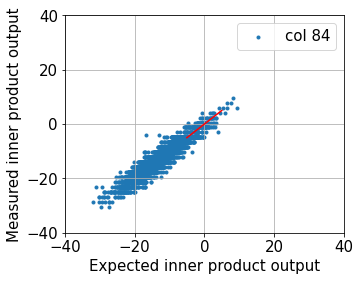

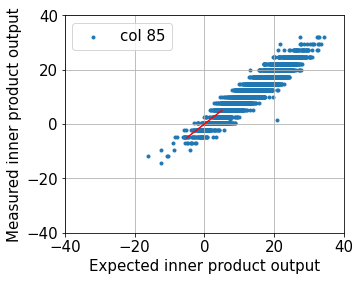

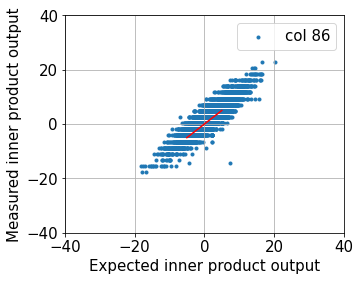

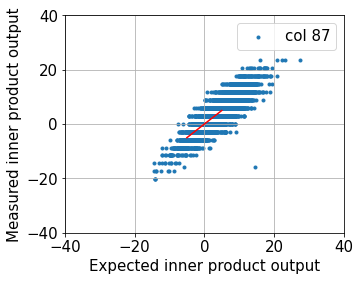

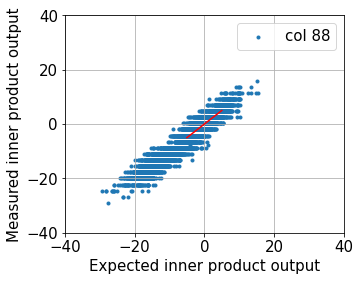

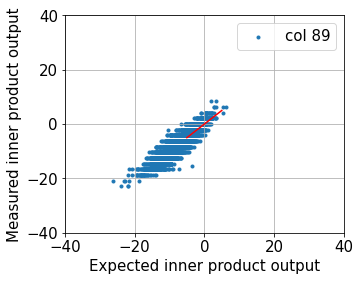

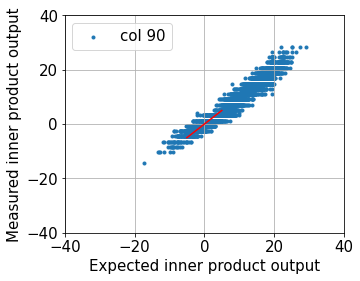

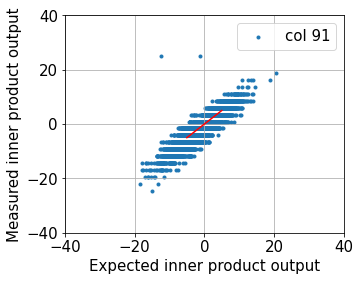

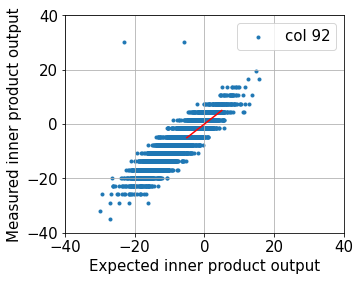

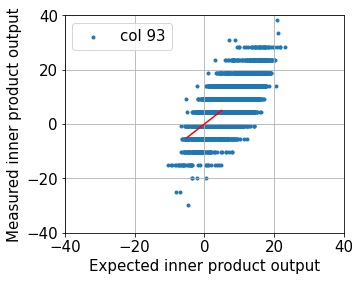

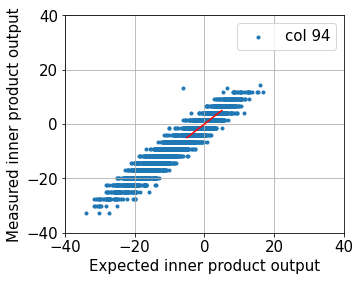

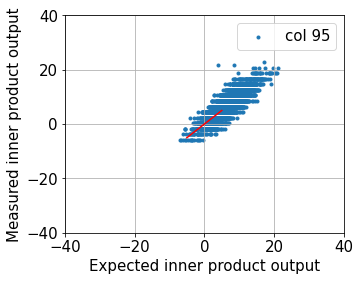

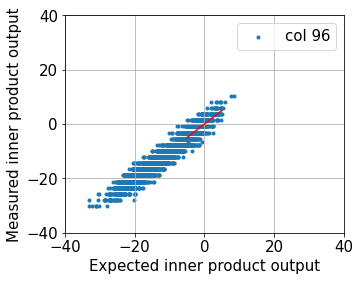

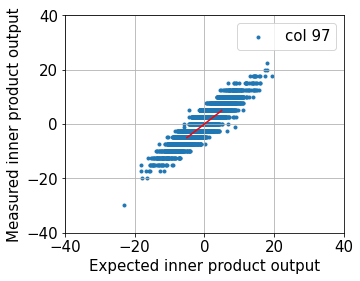

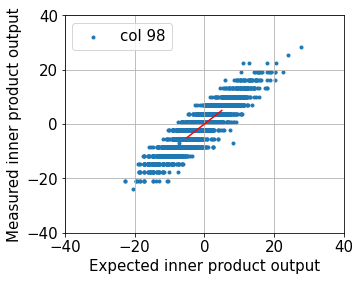

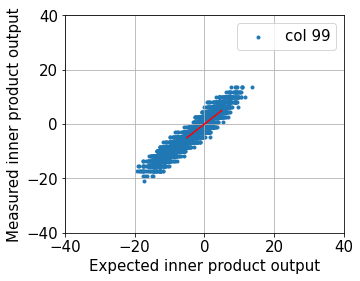

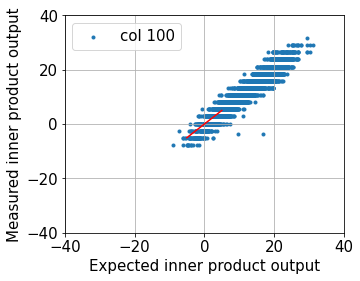

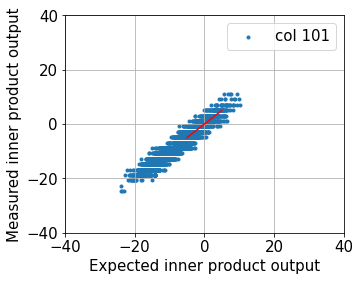

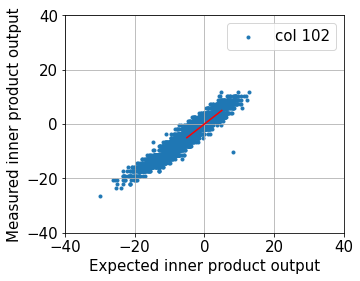

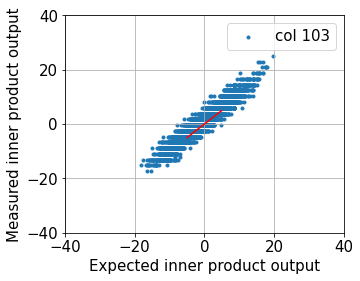

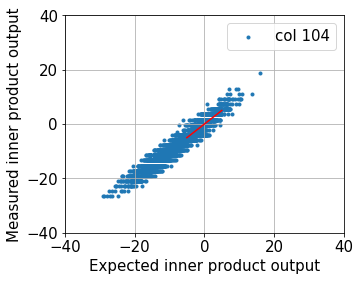

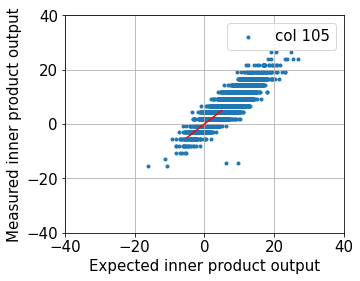

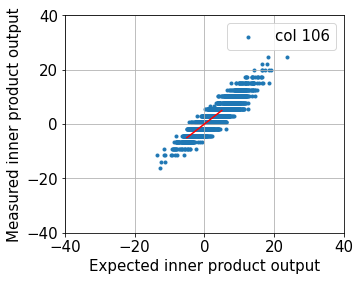

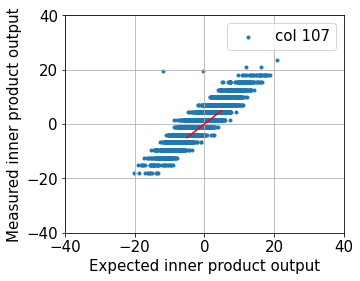

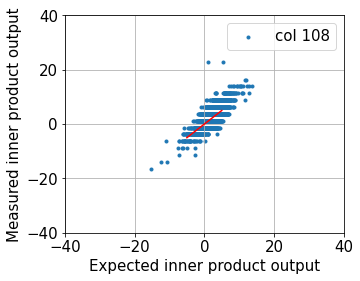

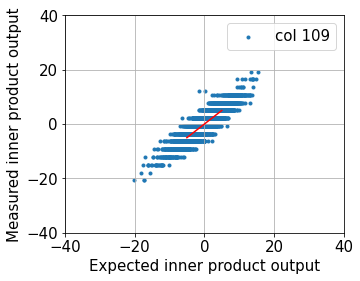

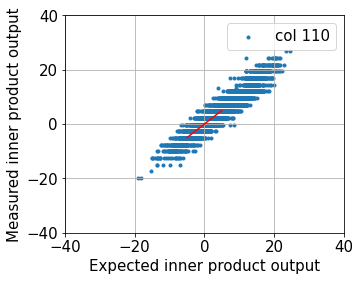

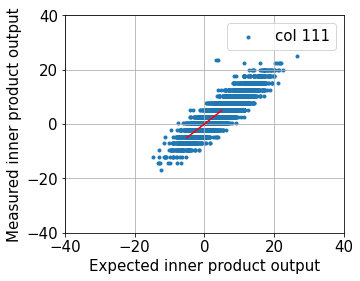

In [54]:
for c in range(112):

    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(5,4))
    plt.scatter(expected_outputs[:, c], actual_outputs[:, c], label='col %d' % c, marker='.')
    plt.plot(np.arange(-5, 6), np.arange(-5, 6), 'r')
    plt.grid()
    plt.xlim(-40, 40)
    plt.ylim(-40, 40)
    plt.xlabel('Expected inner product output')
    plt.ylabel('Measured inner product output')
    plt.legend()
